In [2]:
import os
from Bio.SeqIO import QualityIO
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

import gzip
import glob
import re
from DMS_utils import dna_rev_comp, translate_dna2aa
import pysam
import pandas as pd
import seaborn as sns
import pickle as pkl
import matplotlib.colors as mcolors
from scipy import stats
import os.path
from matplotlib.lines import Line2D
import json
import matplotlib.gridspec as gridspec
import shutil

from evaluation_functions import *
from importlib import reload

In [95]:
# base_dir = os.getcwd() 
# amplicon = "RRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRV"

# amplicon_DNA = 'CGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTG'

# amplicon_DNA_corrected = 'CGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAAGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTG'## since all the sequenced reads have an "A" instead of "G" at the 413th position of the LOV2 gene, we correct the sequence here

# # correct the sequence
# # LOV_gene_corrected = list(LOV_gene)
# # LOV_gene_corrected[413] = "A"
# # LOV_gene_corrected = "".join(LOV_gene_corrected)

# amplicon_start = "CGCCGCATGGAAGCGATTAACGAAAGCAGCGGT"
# amplicon_end = "GGGAGCCTGCATCCGCCGATGGATAACCGCGTG"
# LOV_gene_end_corr = "GAAAACATTGATGAAGCGGCCAAA"
# LOV_gene_corrected = 'TTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAAGCGGCCAAA' ## since all the sequenced reads have an "A" instead of "G" at the 413th position, we correct the sequence here

# LOV_gene = "TTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAA"

# LOV = "LATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAK"
# gene_len = len(LOV)*3
# catch_left = 'AAGCAGCGGT'
# catch_right = 'GGGAGCCTGC'
# offset_left = 3
# offset_right= 5

# genetic_code = {
#   'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
#   'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
#   'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
#   'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
#   'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
#   'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
#   'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
#   'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
#   'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
#   'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
#   'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
#   'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
#   'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
#   'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
#   'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
#   'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W',
# }

# codons = list(genetic_code.keys())


# quality_score = {
#   '!':0, '"':1, '#':2, '$':3, '%':4, '&':5, "'":6, '(':7, ')':8, '*':9,
#   '+':10, ',':11, '-':12, '.':13, '/':14, '0':15, '1':16, '2':17, '3':18, '4':19,
#   '5':20, '6':21, '7':22, '8':23, '9':24, ':':25, ';':26, '<':27, '=':28, '>':29,
#   '?':30, '@':31, 'A':32, 'B':33, 'C':34, 'D':35, 'E':36, 'F':37, 'G':38, 'H':39, 'I':40
# }


# ecoli_pref = { ### codons used for retron library (RL8) construction
#             "A": 'GCG',
#             "R": 'CGT',
#             "N": 'AAC',
#             "D": 'GAT',
#             "C": 'TGC',
#             "Q": 'CAG',
#             "E": 'GAA',
#             "G": 'GGC',
#             "H": 'CAT',
#             "I": 'ATT',
#             "L": "CTG",
#             "K": 'AAA',
#             "M": 'ATG',
#             "F": "TTT",
#             "P": 'CCG',
#             "S": 'AGC',
#             "T": 'ACC',
#             "W": 'TGG',
#             "Y": "TAT",
#             "V": 'GTG',
# }

In [47]:
## reload the evaluation functions
import evaluation_functions
reload(evaluation_functions)
from evaluation_functions import *

In [3]:
base_dir = os.getcwd()
R5_Pool_seq = "GGCGCAACTATCGGTATCAAGCTGTTTAAGAAATTCACCTCGAAAGCAAGTTGATAAACTGATACAATTAAAGGCTCCTTTTGGAGCCTTTTTTTTTGGAGTAAGGAGGAAAAATGTCCGAGGAAGCGCAGAACGATCCGCTGCTGCCGGGCTATAGCTTTAACGCGCATCTGGTGGCGGGCCTGACCCCGATTGAAGCGAACGGCTATCTGGATTTTTTTATTGATCGCCCGCTGGGCATGAAAGGCTATATTCTGAACCTGACCATTCGCGGCCAGGGCGTGGTGAAAAACCAGGGCCGCGAATTTGTGTGCCGCCCGGGCGATATTCTGCTGTTTCCGCCGGGCGAAATTCATCATTATGGCCGCCATCCGGAAGCGCGCGAATGGTATCATCAGTGGGTGTATTTTCGCCCGCGCGCGTATTGGCATGAATGGCTGAACTGGCCGAGCATTTTTGCGAACACCGGCTTTTTTCGCCCGGATGAAGCGCATCAGCCGCATTTTAGCGATCTGTTTGGCCAGATTATTAACGCGGGCCAGGGCGAAGGCCGCTATAGCGAACTGCTGGCGATTAACCTGATAGAACAGCTGCTGCTGCGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGCGAAGCGTGCCAGTATATTAGCGATCATCTGGCGGATAGCAACTTTGATATTGCGAGCGTGGCGCAGCATGTGTGCCTGAGCCCGAGCCGCCTGAGCCATCTGTTTCGCCAGCAGCTGGGCATTAGCGTGCTGAGCTGGCGCGAAGATCAGCGCATTAGCCAGGCGAAACTGCTGCTGAGCACCACCCGCATGCCGATTGCGACCGTGGGCCACAACGTGGGCTTTGATGATCAGCTGTATTTTAGCCGCGTGTTTAAAAAATGCACCGGCGCGAGCCCGAGCGAATTTCGCGCGGGCTGCGAAGAAAAAGTGAACGATGTGGCGGTGAAACTGAGCGGGTAAGGCTAATGGAGATTTTCAACATGGGCTAGCACAGCCCTAGGTATTATGCTAGCGTGGTGTCTGCGTAATAAGGAGTCTTAATCATGCCAGTTC"

catch_left = "ACACTCTTTCCCTACACGACGCTCTTCCGATCT" ## Adapter fwd
catch_right = "GACTGGAGTTCAGACGTGTGCTCTTCCGATCT"

Barcodes = {"BC1_Fwd": "AAGG",
            "BC1_Rev": "ATCA",
            "BC2_Fwd": "AGTC",
            "BC2_Rev": "GCCG",
            "BC3_Fwd": "AGGA",
            "BC3_Rev": "AATT",
            "BC4_Fwd": "GCGA",
            "BC4_Rev": "TGGT",
            }

S1_fwd_primer = "GGCGCAACTATCGGTATCAAGC"
S1_rev_primer = "TCGGCCAGTTCAGCCATTCA"
S1_rev_primer_compseq = dna_rev_comp(S1_rev_primer)
S2_fwd_primer = "ATTATGGCCGCCATCCGGAAGCG"
S2_rev_primer = "TAGCACGGTCAGTCTCTGGC"
S2_rev_primer_compseq = dna_rev_comp(S2_rev_primer)
S3_fwd_primer = "GTCCGATAGCTTCCTGCAATTAACC"
S3_rev_primer = "ACATGCTGCGCCACGCTC"
S3_rev_primer_compseq = dna_rev_comp(S3_rev_primer)
S4_fwd_primer = "GATAACCGCGTGCGCGAA"
S4_rev_primer = "GAACTGGCATGATTAAGACTCCTTATTACG" 
S4_rev_primer_compseq = dna_rev_comp(S4_rev_primer)

Primer_seq = dict(
            S1_fwd_primer = "GGCGCAACTATCGGTATCAAGC",
            S1_rev_primer = "TCGGCCAGTTCAGCCATTCA",
            S2_fwd_primer = "ATTATGGCCGCCATCCGGAAGCG",
            S2_rev_primer = "TAGCACGGTCAGTCTCTGGC",
            S3_fwd_primer = "GTCCGATAGCTTCCTGCAATTAACC",
            S3_rev_primer = "ACATGCTGCGCCACGCTC",
            S4_fwd_primer = "GATAACCGCGTGCGCGAA",
            S4_rev_primer = "GAACTGGCATGATTAAGACTCCTTATTACG" 
)

genetic_code = {
  'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
  'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
  'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
  'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
  'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
  'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
  'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
  'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
  'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
  'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
  'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
  'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
  'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
  'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
  'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
  'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W',
}

codons = list(genetic_code.keys())

quality_score = {
  '!':0, '"':1, '#':2, '$':3, '%':4, '&':5, "'":6, '(':7, ')':8, '*':9,
  '+':10, ',':11, '-':12, '.':13, '/':14, '0':15, '1':16, '2':17, '3':18, '4':19,
  '5':20, '6':21, '7':22, '8':23, '9':24, ':':25, ';':26, '<':27, '=':28, '>':29,
  '?':30, '@':31, 'A':32, 'B':33, 'C':34, 'D':35, 'E':36, 'F':37, 'G':38, 'H':39, 'I':40
}

Primer_out_of_triplets = {"S1_fwd_primer": 2,
                     "S1_rev_primer": 1, 
                     "S2_fwd_primer": 2,
                     "S2_rev_primer": 1,
                     "S3_fwd_primer": 1,
                     "S3_rev_primer": 2,
                     "S4_fwd_primer": 0,
                     "S4_rev_primer": 3} ##?



# Functions

In [16]:
## add numbers of positions to the sequence
R5_Pool_AA = translate_dna2aa(R5_Pool_seq[2:])
AraC_AA_start_pos = 37
LOV2_AA_start_pos = 210
LOV2_AA_end_pos = 351# len 145
AraC_end_pos = 477 # len 124

AA_berfore_AraC_start = [R5_Pool_AA[i] for i in range(AraC_AA_start_pos)]
AA_AraC_part1 = [R5_Pool_AA[i]+str(i-AraC_AA_start_pos) for i in range(AraC_AA_start_pos,LOV2_AA_start_pos-2)]
AA_linker1 = [R5_Pool_AA[i]+str(i+1-LOV2_AA_start_pos+2) for i in range(LOV2_AA_start_pos-2,LOV2_AA_start_pos)]
AA_Lov2 = [R5_Pool_AA[i]+str(404+i-LOV2_AA_start_pos) for i in range(LOV2_AA_start_pos,LOV2_AA_end_pos)]
AA_linker2 = [R5_Pool_AA[i]+str(i+1-LOV2_AA_end_pos+2) for i in range(LOV2_AA_end_pos,LOV2_AA_end_pos+2)]
AA_AraC_part2 = [R5_Pool_AA[i]+str((LOV2_AA_start_pos-2-AraC_AA_start_pos)+i-(LOV2_AA_end_pos+2)) for i in range(LOV2_AA_end_pos+2,AraC_end_pos )]
AA_after_AraC = [R5_Pool_AA[i] for i in range(AraC_end_pos,len(R5_Pool_AA))]

R5_Pool_AA_annot = AA_berfore_AraC_start + AA_AraC_part1 + AA_linker1 + AA_Lov2 + AA_linker2 + AA_AraC_part2 + AA_after_AraC

In [73]:
## evaluation 

### calculate sum of single, double and triple mutants
def gather_n_mutations(a_seq, b_seq, reference_seq, use_backward_read = True, use_forward_read = True, use_triplets = False):
    """
    returns a dictionary with the number of single, double, triple (...) mutants
    a_seq, b_seq = list of sequences
    """
    mutation_dict = {}
    catch_length = len(catch_left)    
    
    for a_seq, b_seq in zip(a_seq, b_seq):
        
        if use_forward_read and catch_left in a_seq:
            index = a_seq.index(catch_left) + catch_length
            gene_a = a_seq[index:]
            if use_triplets: 
                n_muts_a_seq = sum([reference_seq[i:i+3] != gene_a[i:i+3] for i in range(0,len(gene_a)//3*3,3)])
            else: 
                n_muts_a_seq = sum([reference_seq[i] != gene_a[i] for i in range(len(gene_a))])

        else: n_muts_a_seq = 0
            
        if use_backward_read and dna_rev_comp(catch_right) in b_seq:
                index = b_seq.index(dna_rev_comp(catch_right)) + catch_length
                gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
                gene_b = gene_b[::-1]
                n_muts_b_seq = sum([reference_seq[::-1][i] != gene_b[i] for i in range(len(gene_b))])
                
        else: n_muts_b_seq = 0

        n_muts = n_muts_a_seq + n_muts_b_seq

        if n_muts in mutation_dict:
            mutation_dict[n_muts] += 1
        else:
            mutation_dict[n_muts] = 1

    return mutation_dict


### calculate the mutagenic spectrum
def mut_spectrum(a_seq, b_seq, reference_seq, use_backward_read = True, use_forward_read = True, catch_left = catch_left, catch_right = catch_right):
    """
    input: 
    a_seq, b_seq = list of sequences
    reference_seq = reference sequence
    
    returns two dictionaries: (1) with the total counts of the mutagenic spectrum and (2) dict with percentage of the mutagenic spectrum
    with the following structure: {reference nt: {mutated nt: count/percentage}}
    """
    ## reference nt : {mutated nt: count}
    mut_spec = {'A': {'A':0, 'C':0, 'G':0, 'T':0},
                'C': {'A':0, 'C':0, 'G':0, 'T':0},
                'G': {'A':0, 'C':0, 'G':0, 'T':0},
                'T': {'A':0, 'C':0, 'G':0, 'T':0}}
    
    for a_seq, b_seq in zip(a_seq, b_seq):
                
        if use_forward_read: 
            if catch_left in a_seq:
                index = a_seq.index(catch_left) + len(catch_left)
                gene_a = a_seq[index:]
            
                for idx, nt in enumerate(gene_a): 
                    if reference_seq[idx] != nt:
                        mut_spec[reference_seq[idx]][nt] += 1
                
        if use_backward_read:        
            if dna_rev_comp(catch_right) in b_seq:
                index = b_seq.index(dna_rev_comp(catch_right)) + len(catch_right)
                gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
                gene_b = gene_b[::-1]

                for idx, nt in enumerate(gene_b):
                    if reference_seq[::-1][idx] != nt:
                        mut_spec[reference_seq[::-1][idx]][nt] += 1
    
    ## calculate mutagenic spectrum in percentage
    total_n_muts = sum([sum(value.values()) for value in mut_spec.values()])
    mut_spec_perc = {ref_base: {mut_base: round(val/total_n_muts*100, 3) for mut_base, val in value.items()} for ref_base, value in mut_spec.items()}

    return mut_spec, mut_spec_perc

### calculate the mutagenic spectrum codon-wise
def mut_spectrum_codons(a_seq, b_seq, reference_seq, use_backward_read = False, use_forward_read = True, codon_list = codons, catch_left = catch_left, catch_right = catch_right):
    """
    input: 
    a_seq, b_seq = list of sequences
    reference_seq = reference sequence
    
    returns two dictionaries: (1) with the total counts of the mutagenic spectrum of codons and (2) dict with percentage of the mutagenic spectrum
    with the following structure: {reference codon: {mutated codon: count/percentage}}
    """
    ## reference codon : {mutated codon: count}
    mut_spec = {ref_codon: {codon:0 for codon in codon_list} for ref_codon in codon_list}

    for a_seq, b_seq in zip(a_seq, b_seq):
                
        if use_forward_read: 
            if catch_left in a_seq:
                index = a_seq.index(catch_left) + len(catch_left)
                gene_a = a_seq[index:]
                
                for idx in range(0,len(gene_a)//3*3,3): 
                    if reference_seq[idx:idx+3] != gene_a[idx:idx+3]:
                        mut_spec[reference_seq[idx:idx+3]][gene_a[idx:idx+3]] += 1
                
        if use_backward_read:        
            if dna_rev_comp(catch_right) in b_seq:
                index = b_seq.index(dna_rev_comp(catch_right)) + len(catch_right)
                gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
                gene_b = gene_b[::-1]
                
                for idx in range(0,len(gene_b)//3*3,3):
                    if reference_seq[::-1][idx:idx+3] != gene_b[idx:idx+3]:
                        mut_spec[reference_seq[::-1][idx:idx+3]][gene_b[idx:idx+3]] += 1
    
    ## calculate mutagenic spectrum in percentage
    total_n_muts = sum([sum(value.values()) for value in mut_spec.values()])
    mut_spec_perc = {ref_base: {mut_base: round(val/total_n_muts*100, 3) for mut_base, val in value.items()} for ref_base, value in mut_spec.items()}

    return mut_spec, mut_spec_perc


def plot_mutation_spectrum(data, samplename , fig_folder = None, colormap = "viridis"):
    """
    plot mutation spectrum (%) as heatmap
    data = dataframe with the mutagenic spectrum (rows = reference nt, columns = mutated nt)
    savepath = folder path to save the figure
    """
    f, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(data, annot=True, linewidths=.5, ax=ax, vmin = 0, cbar = False, square = True, linecolor = "black", cmap = colormap)
    plt.xlabel('Mutated base (%)', fontsize = 10)
    plt.ylabel('Reference base (%)', fontsize = 10)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(.5)
    #ax.set_facecolor('gray')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=1, fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=1, fontsize=10)
    plt.title(f"{samplename} mutagenic spectrum", fontsize = 12)
    if fig_folder is not None:
        plt.savefig(f"{fig_folder}/{samplename}_mutagenic_spectrum_perc.pdf")
    plt.show()
    plt.clf()

def coverage_plot(data, variant_name = "", xticks = list(range(0,430, 50)), FigFolder = None): 
    """
    data is a df with the coverage of each position, e.g by calling seq_variants["DNA"].sum()
    """

    ## plot coverage 

    ax = sns.barplot(data)
    plt.xticks(xticks)
    plt.xlabel("Position")
    plt.ylabel("Read counts")
    plt.title(f'{variant_name} DNA coverage')
    if FigFolder:
        plt.savefig(f'{FigFolder}/{variant_name}_DNA_coverage.pdf')
    return ax

def plot_mut_rate_per_pos(data, variant_name, FigFolder, ref_seq ):
    """
    data is a df with the mutation rate of each position, e.g by calling DNA_relative.sum()-DNA_relative.max() or seq_variants["DNA"].sum()-seq_variants["DNA"].max()/seq_variants["DNA"].sum()
    """
    plt.figure(figsize=(20,2))
    x_ticklabels = [Nt for Nt in ref_seq[:len(data)]]
    sns.heatmap(pd.DataFrame(data).T, cmap = "viridis", cbar = True, cbar_kws = {"pad": 0.02, "label": "Mutation rate" },linecolor="black", xticklabels=x_ticklabels, yticklabels=False)
    #ax.set_xticks(ticks = list(range(len(mut_rate_per_pos))),  labels = [Nt for Nt in LOV_gene[:len(mut_rate_per_pos)]])
    plt.xlabel("Position")
    plt.xticks(rotation = 2,fontsize=6)
    plt.title(variant_name)
    #plt.savefig(f"{FigFolder}/{name}_mutation_rate_per_Nt_position.pdf", bbox_inches="tight")
    plt.show()
    plt.clf()

# AraC analysis

### NOTE that the quality score cutoff is set to a 1 % error rate

In [4]:
remove_read_qualities = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', ]#'.', '/']

a_seq, b_seq, _, _, a_ids, b_ids= read_sequences(variant = "Mutagenesis", arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left="", catch_right="", return_qualities_ids=True, quality_score=remove_read_qualities)
ref_gene = R5_Pool_seq

Mutagenesis_reads, Mut_ids_Dict = demultiplex_reads(a_seq, b_seq, ref_gene,Barcodes=Barcodes, Primer_seq=Primer_seq, used_Barcodes = ["BC1", "BC2"], Sections = ["S1", "S2", "S3", "S4"], max_mismatch_primerseq = 3, filter_for_n_mut = True, n_mut_treshold = 10, a_ids=a_ids, b_ids=b_ids)

a_seq, b_seq, _, _, a_ids, b_ids = read_sequences(variant = "NegPosSelection", arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left="", catch_right="", return_qualities_ids=True, quality_score=remove_read_qualities)

NegPosSelection_reads, NegPos_ids = demultiplex_reads(a_seq, b_seq, ref_gene,Barcodes=Barcodes, Primer_seq=Primer_seq, used_Barcodes = ["BC1", "BC2", "BC3", "BC4"], Sections = ["S1", "S2", "S3", "S4"], max_mismatch_primerseq = 3, filter_for_n_mut = True, n_mut_treshold = 10, a_ids=a_ids, b_ids=b_ids)

all_reads = {**{"Mutagenesis_"+key : value for key, value in Mutagenesis_reads.items()},**{"NegPosSelection_"+key : value for key, value in NegPosSelection_reads.items()}}

all_ids = {**{"Mutagenesis_"+key : value for key, value in Mut_ids_Dict.items()},**{"NegPosSelection_"+key : value for key, value in NegPos_ids.items()}}

total reads 32117
BC1
total forward reads before filtering 3907
total reverse reads before filtering 3907
total forward reads after filtering 3079
total reverse reads after filtering 3186
3907 reads
total forward reads before filtering 4347
total reverse reads before filtering 4347
total forward reads after filtering 3395
total reverse reads after filtering 3312
4347 reads
total forward reads before filtering 5561
total reverse reads before filtering 5561
total forward reads after filtering 4529
total reverse reads after filtering 4236
5561 reads
total forward reads before filtering 6086
total reverse reads before filtering 6086
total forward reads after filtering 4956
total reverse reads after filtering 5151
6086 reads
BC2
total forward reads before filtering 4193
total reverse reads before filtering 4193
total forward reads after filtering 3093
total reverse reads after filtering 3542
4193 reads
total forward reads before filtering 3735
total reverse reads before filtering 3735
total

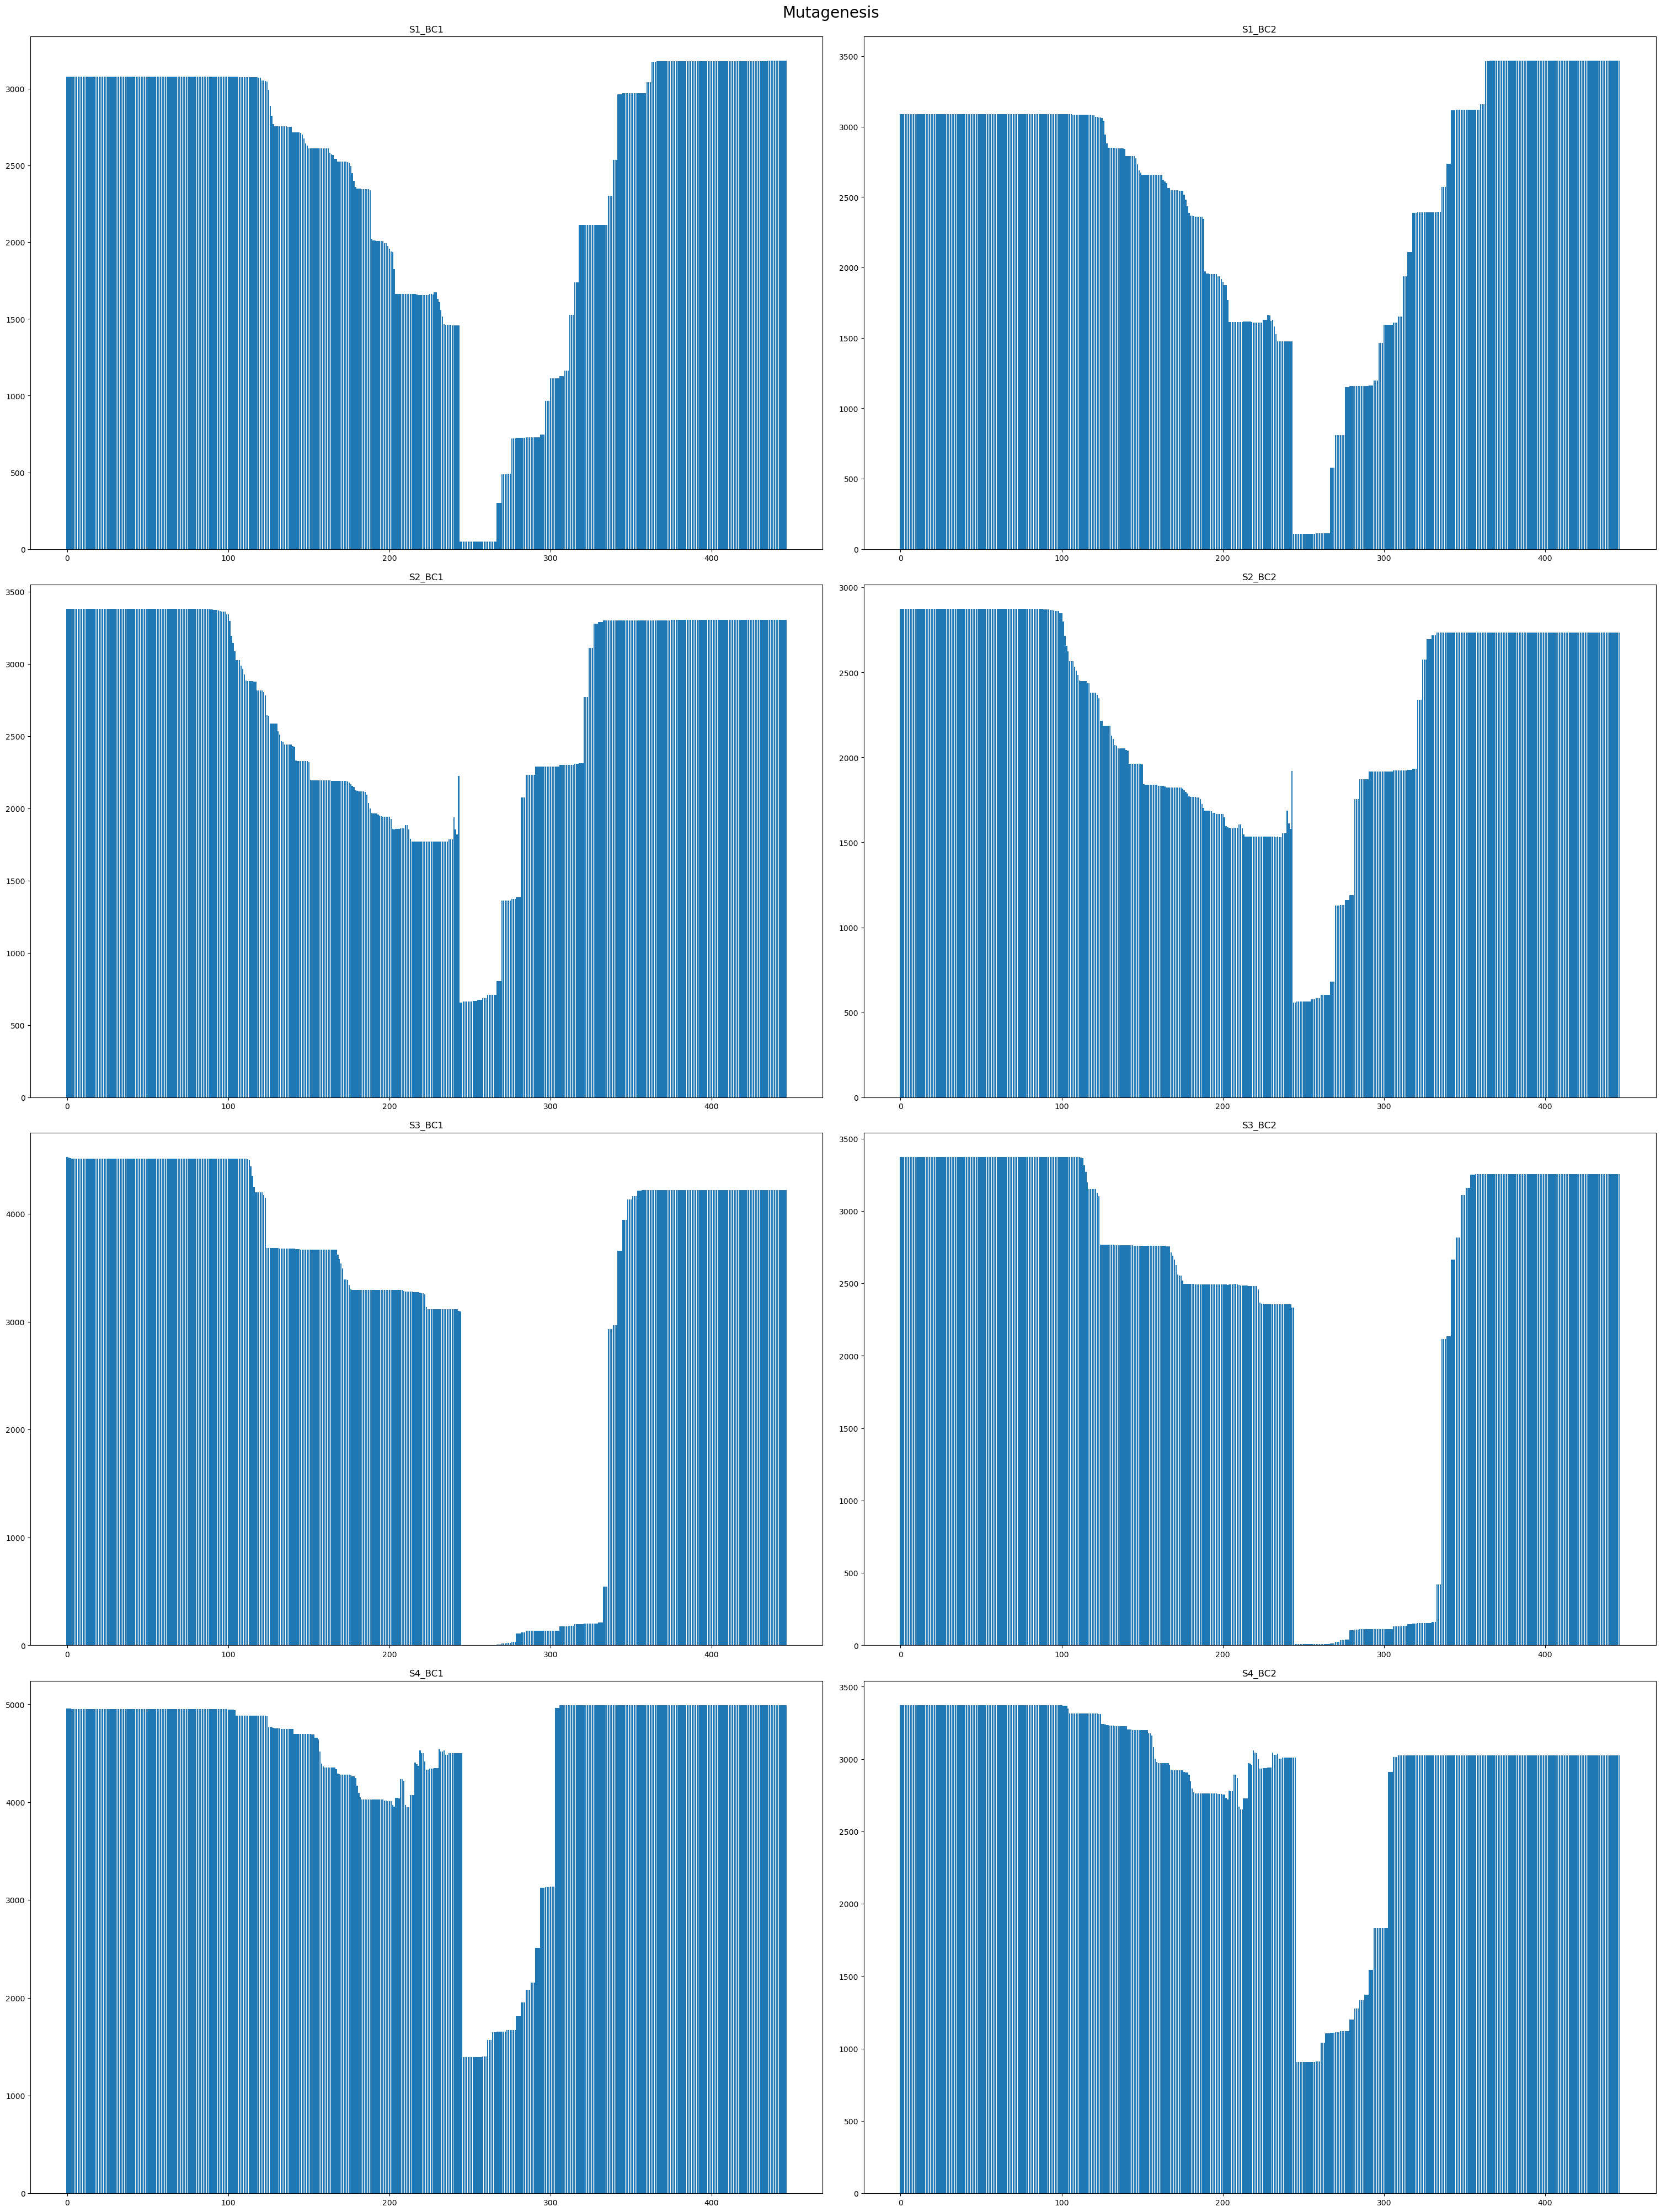

In [63]:
## figure with 4x4 plots of coverages: 
read_dictionary =Mutagenesis_reads
plt_title = "Mutagenesis"
used_Barcodes = ["BC1", "BC2"]#, "BC3", "BC4"]
Sections = ["S1", "S2", "S3", "S4"]

fig, axs = plt.subplots( len(Sections),len(used_Barcodes), figsize=(15*len(used_Barcodes), 10*len(Sections)), layout='constrained')

for Bc in used_Barcodes: 
    for Section in  Sections:
        name = f"{Bc}_{Section}"

        tripl_st = Primer_out_of_triplets[Section+"_fwd_primer"]
        tripl_end = Primer_out_of_triplets[Section+"_rev_primer"]
        ref_seq_Section = ref_gene[ref_gene.index(Primer_seq[Section + "_fwd_primer"][tripl_st:]):ref_gene.index(dna_rev_comp(Primer_seq[Section+"_rev_primer"][tripl_end:]))+len(Primer_seq[Section+"_rev_primer"][tripl_end:])]
        ref_prot_section = translate_dna2aa(ref_seq_Section)

        seq_variants = get_variants(read_dictionary[f"{Bc}_{Section}_R1"], read_dictionary[f"{Bc}_{Section}_R2"], catch_left=Barcodes[f"{Bc}_Fwd"]+Primer_seq[Section + "_fwd_primer"][:tripl_st],catch_right=dna_rev_comp(Barcodes[f"{Bc}_Rev"]+Primer_seq[Section+"_rev_primer"][:tripl_end]), ref_prot = ref_prot_section, ref_gene = ref_seq_Section, codons = codons)

        seq_variants["DNA"] = pd.DataFrame.from_dict(seq_variants["DNA"])
        #seq_variants["DNA"] = seq_variants["DNA"].loc[:,seq_variants["DNA"].sum() > 0]
        seq_variants["AA"] = pd.DataFrame.from_dict(seq_variants["AA"])
        #seq_variants["AA"] = seq_variants["AA"].loc[:,seq_variants["AA"].sum() > 0]
        seq_variants["Codons"] = pd.DataFrame.from_dict(seq_variants["Codons"])
        #seq_variants["Codons"] = seq_variants["Codons"].loc[:,seq_variants["Codons"].sum() > 0]

        ax = axs[Sections.index(Section), used_Barcodes.index(Bc)]
        ax.bar(seq_variants["DNA"].sum().index, seq_variants["DNA"].sum())
        ax.set_title(f'{Section}_{Bc}')
    
fig.suptitle(plt_title, fontsize = 20)      
#plt.savefig(f'/Users/annavonbachmann/Documents/GitHub/DMS_analysis/output/PACE/Mutagenesis_final_DNA_coverage.pdf')                                                            
plt.show()

In [178]:
high_mut_pos_dict = {"S1":[], "S2":[], "S3":[], "S4":[]}
low_cov_pos_dict = {"S1":[], "S2":[], "S3":[], "S4":[]}
for cyclename in ["Mutagenesis", "NegPosSelection"]:
    used_Barcodes = ["BC1", "BC2"] if cyclename == "Mutagenesis" else ["BC1", "BC2", "BC3", "BC4"]
    for section in ["S1", "S2", "S3", "S4"]:
        for Bc in used_Barcodes:
            high_mut_positions,low_cov_pos = find_mutated_pos(read_dict = all_reads, Barcode=Bc, Section=section, ref_gene =ref_gene, Primer_seq=Primer_seq, Primer_out_of_triplets=Primer_out_of_triplets, codons =codons, data_type = "AA", filter_treshold=0.03,cyclename = cyclename, cov_filter_treshold = 50)
            high_mut_pos_dict[section].extend(high_mut_positions)
            low_cov_pos_dict[section].extend(low_cov_pos)

high_mut_pos_dict= {sec: list(set(mut_pos)) for sec, mut_pos in high_mut_pos_dict.items()}


high_mut_pos_dict = {sec:[mut_pos for mut_pos in mut_positions if mut_pos not in low_cov_pos_dict[sec] ] for sec, mut_positions in high_mut_pos_dict.items() }## filter out low coverage positions        

## order dict values
high_mut_pos_dict = {key: [pos for pos in sorted(value)] for key, value in high_mut_pos_dict.items()}

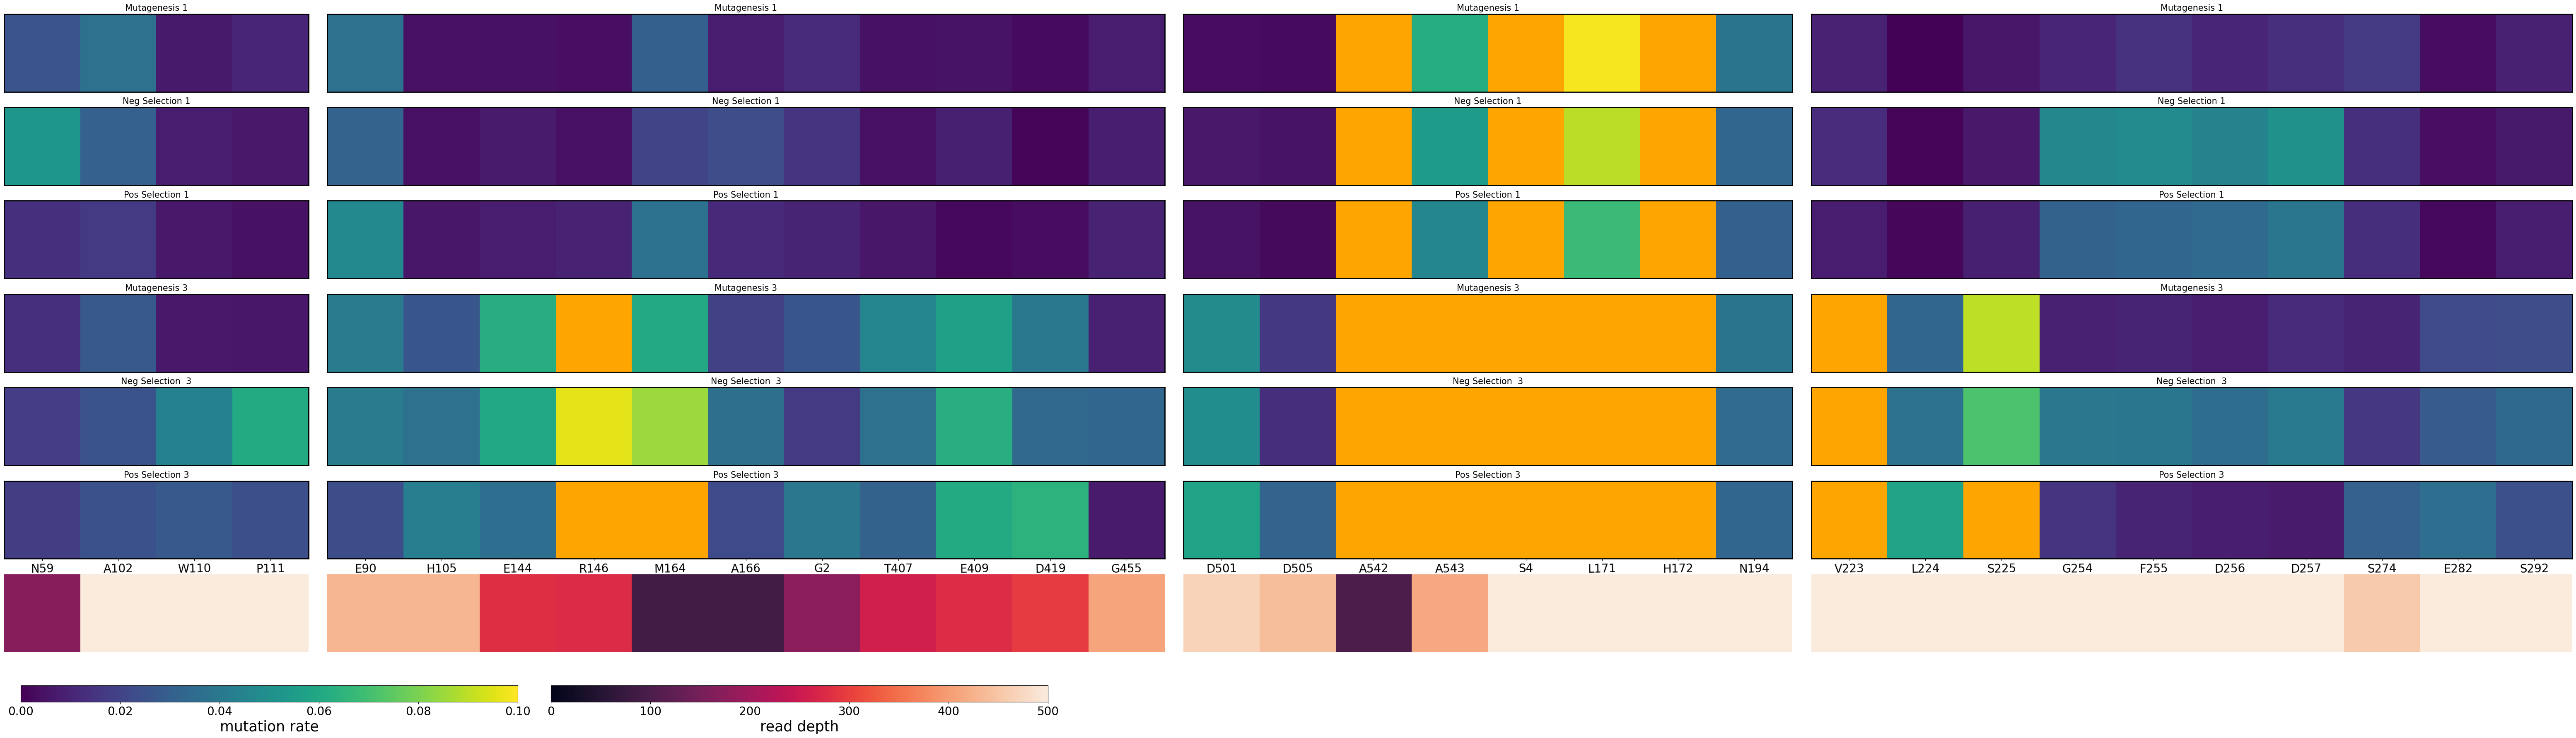

In [182]:
compare_mut_enrichement_for_all(all_reads, ref_gene, Primer_out_of_triplets, Barcodes ,Primer_seq , codons, Sections = ["S1", "S2", "S3", "S4"], use_backward_read =True, use_forward_read= True, xlim_plot = None,FigFolder = None, data_type = "AA", combine_mut_rates =True,show_only_pos=high_mut_pos_dict, vmax=0.1, xlabelticks=R5_Pool_AA_annot)

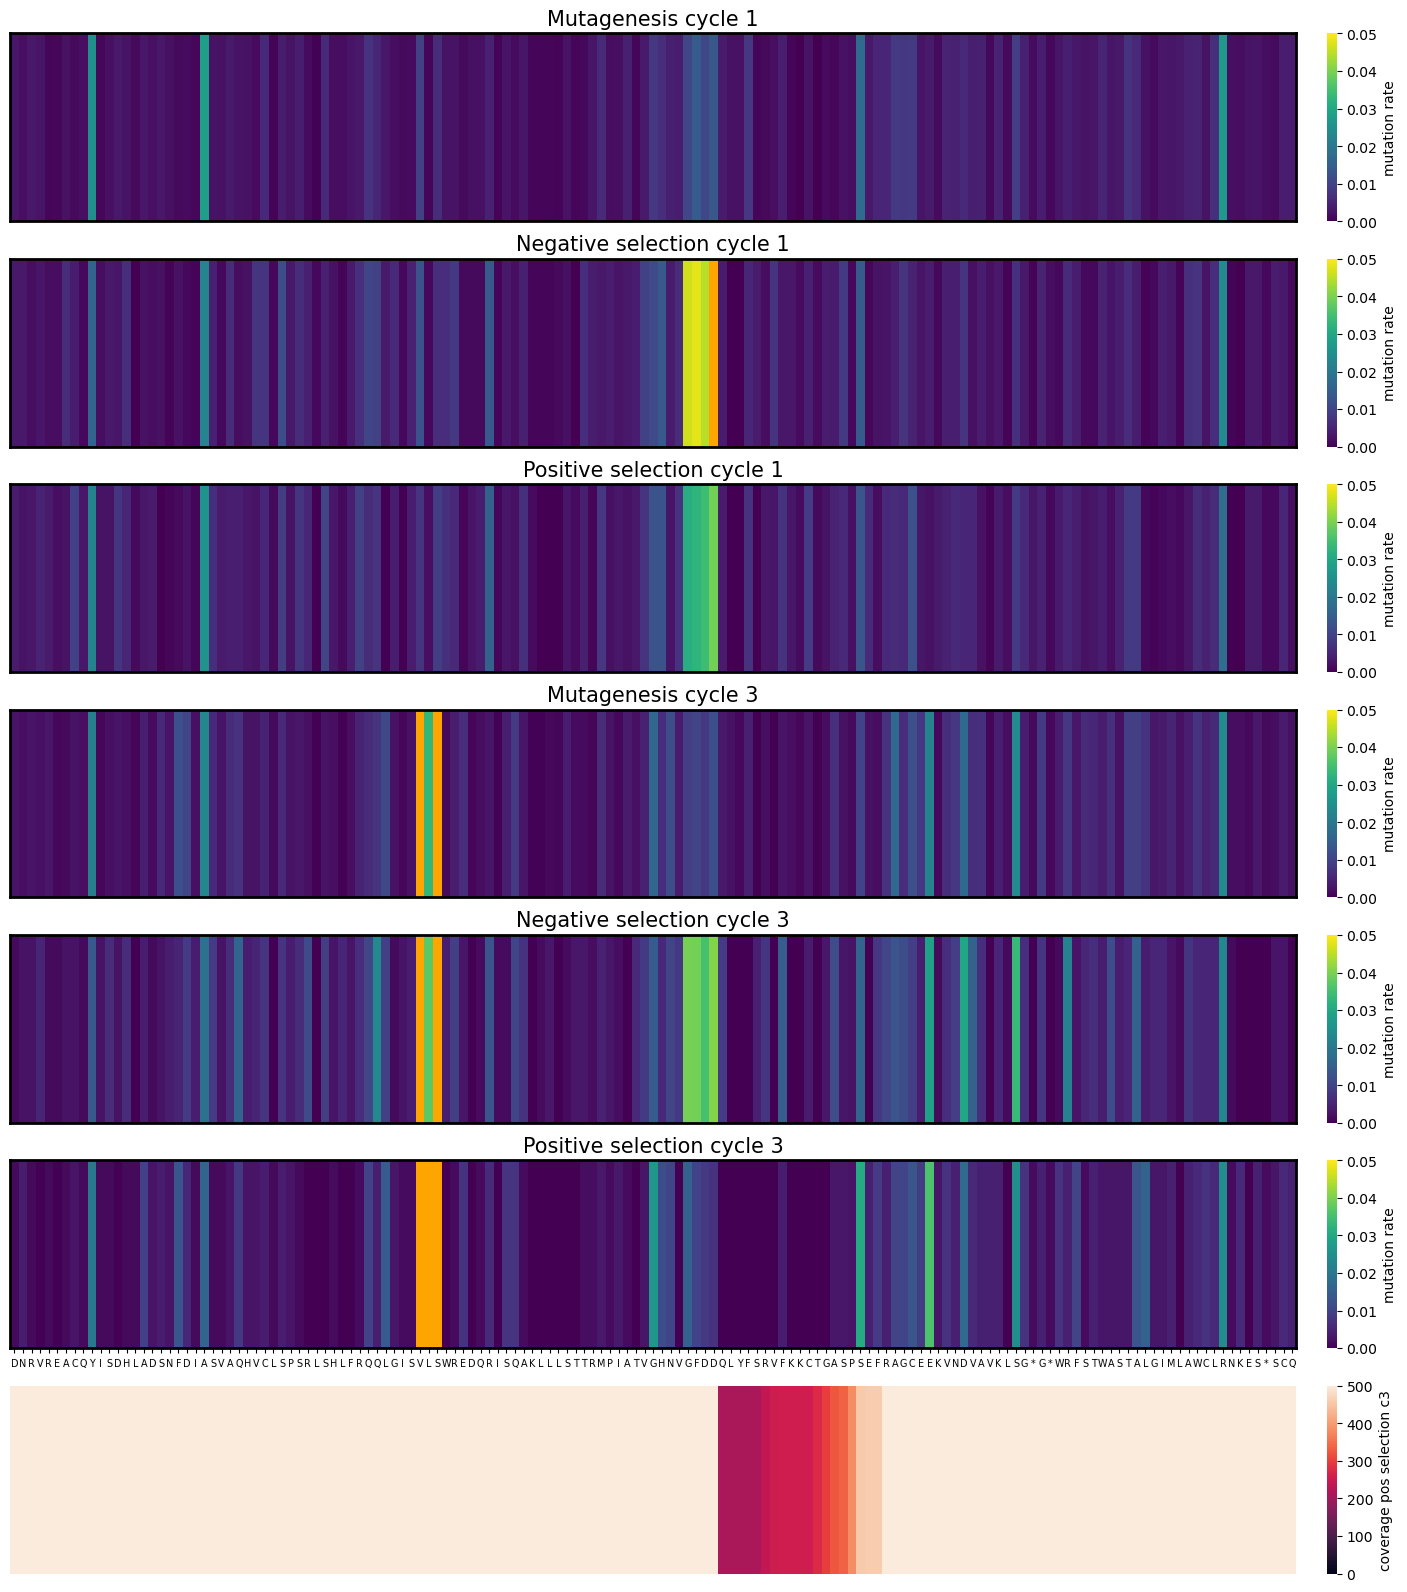

<Figure size 640x480 with 0 Axes>

In [183]:
compare_mut_enrichement(all_reads, "S4", ref_gene, use_backward_read =True, use_forward_read= True, data_type = "AA", combine_mut_rates=True, FigFolder=None, vmax = 0.05, Primer_out_of_triplets=Primer_out_of_triplets, Barcodes=Barcodes, Primer_seq= Primer_seq, codons=codons)

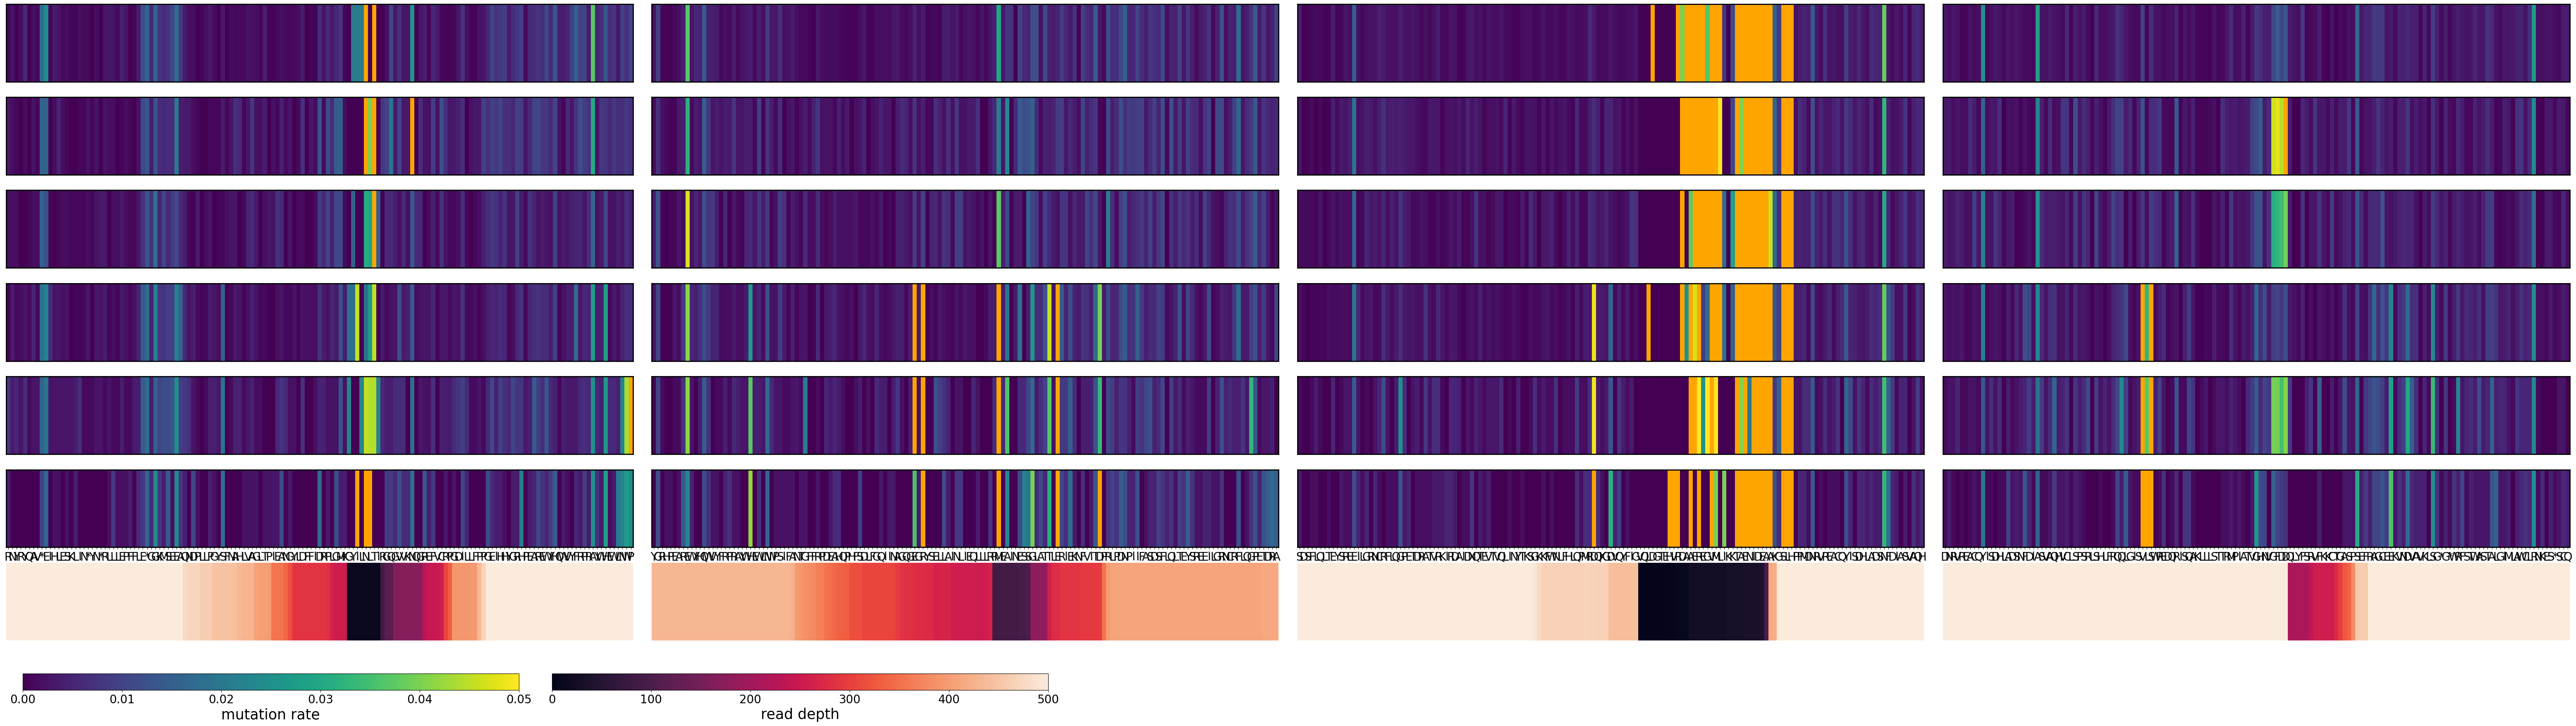

In [184]:
FigFolder = os.path.join(base_dir, "output/PACE/cycle_mut_enrichment")
compare_mut_enrichement_for_all(all_reads, ref_gene, use_backward_read =True, use_forward_read= True, data_type = "AA", combine_mut_rates=True, FigFolder=FigFolder, Primer_out_of_triplets=Primer_out_of_triplets, Barcodes=Barcodes, Primer_seq= Primer_seq, codons=codons, vmax =0.05, show_cbar_for_each = False, show_plttitles = False)

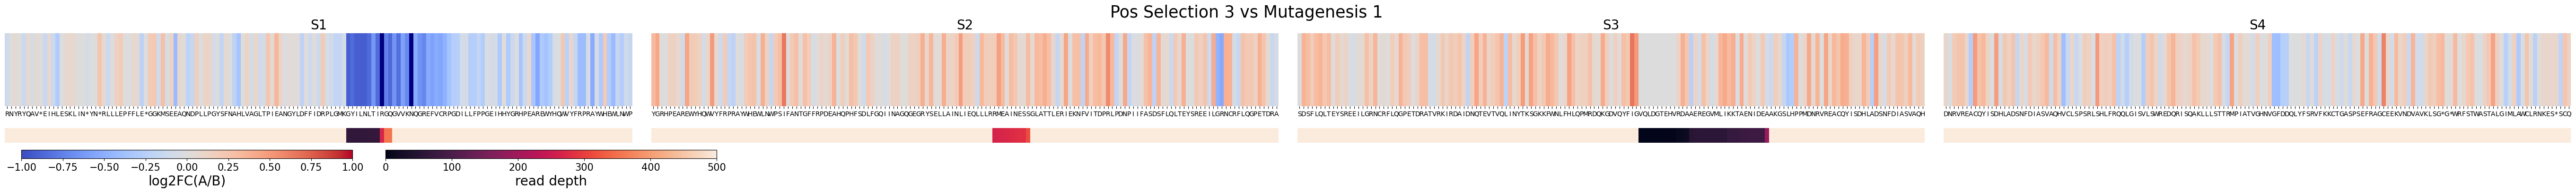

In [60]:
#figfolder = "output/PACE/cycle_mut_enrichment"
CycleA = "NegPosSelection"#"Mutagenesis"
BarcodeA = "BC2"
CylceB = "NegPosSelection" #"Mutagenesis"
BarcodeB = "BC1"
Sections = ["S1", "S2", "S3", "S4"]
name = "Pos Selection 3 vs Mutagenesis 1"
combine_mut_rates=True
vmax = 1
show_cbar_for_each = False
cbar_label = "log2FC(A/B)"

fig = plt.figure(figsize=(70, 3))
gs = gridspec.GridSpec(2, 4, height_ratios=[1, 0.2], width_ratios=[1, 1, 1, 1])

axes = []
for i in range(2):
    row_axes = []
    for j in range(4):
        ax = fig.add_subplot(gs[i, j])
        row_axes.append(ax)
    axes.append(row_axes)

fig.suptitle(name, fontsize = 25, y=1.08)

fig.subplots_adjust(wspace=0.03, hspace=0.5)

for idx, Section in enumerate(Sections): 
    stepA = f"{CycleA}_{BarcodeA}_{Section}"
    stepB = f"{CylceB}_{BarcodeB}_{Section}"

    FC_variants, ref, coverage_A, coverage_B = calculate_log_FC(read_dictionary=all_reads, stepA=stepA, stepB=stepB, Section=Section, BarcodeA=BarcodeA, BarcodeB=BarcodeB, Primer_out_of_triplets=Primer_out_of_triplets,codons=codons,Primer_seq=Primer_seq, Barcodes=Barcodes, ref_gene=ref_gene,data_type="AA", combine_mut_rates=combine_mut_rates)

    my_cmap = plt.get_cmap('coolwarm').copy()
    my_cmap.set_over('saddlebrown')
    my_cmap.set_under('navy')


    #plot_mutation_enrichment(FC_variants,  name = f"{stepA} vs {stepB}", ref_seq=ref, data_type = "AA", fig_folder= None, cmap = "coolwarm", cbar_label=f"log2FC({stepA}/{stepB})", vmax = 0.05)  
    sns.heatmap(pd.DataFrame(FC_variants).T ,cmap = my_cmap, xticklabels=ref, yticklabels=not combine_mut_rates, center = 0, ax = axes[0][idx], cbar = show_cbar_for_each, vmax = vmax, vmin = -vmax if vmax else None ,square = not combine_mut_rates)
    axes[0][idx].set_title(Section, fontsize = 20)
    axes[0][idx].set_xticklabels(axes[0][idx].get_xticklabels(), rotation=1, fontsize=10)
    sns.heatmap(pd.DataFrame(coverage_A).T, linecolor="black", xticklabels=False, yticklabels=False, ax = axes[1][idx], cbar = show_cbar_for_each, vmax = 500, vmin = 0)

if not show_cbar_for_each:
    ## add at the bottom of the figure horizontally a cbar for the relative counts
    cbar_ax = fig.add_axes([0.13, 0, 0.1, 0.06])
    cbar = fig.colorbar(axes[0][0].collections[0], cax=cbar_ax, orientation = "horizontal")
    cbar.set_label(cbar_label, fontsize = 20)
    cbar.ax.tick_params(labelsize=15)

    # fig.subplots_adjust(right=0.8)
    # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    # cbar = fig.colorbar(axes[0,0].collections[0], cax=cbar_ax)
    # cbar.set_label('relative counts', fontsize = 20)
    # cbar.ax.tick_params(labelsize=15)

    # ## ad cbar also for coverage
    cbar_ax = fig.add_axes([0.24, 0, 0.1, 0.06])
    cbar = fig.colorbar(axes[1][3].collections[0], cax=cbar_ax, orientation = "horizontal")
    cbar.set_label('read depth', fontsize = 20)
    cbar.ax.tick_params(labelsize=15)

#plt.savefig(figfolder + f'/{name.replace(" ", "_")}_log2FC.pdf', bbox_inches="tight")

plt.show()
plt.close()

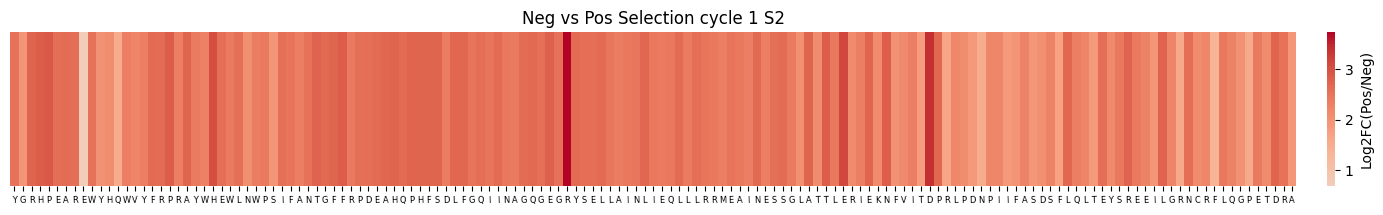

In [53]:
CycleA = "NegPosSelection"#"Mutagenesis"
BarcodeA = "BC4"
CylceB = "Mutagenesis"
BarcodeB = "BC1"
Section = "S2"

stepA = f"{CycleA}_{BarcodeA}_{Section}"
stepB = f"{CylceB}_{BarcodeB}_{Section}"



FC_variants, ref, _,_ = calculate_log_FC(read_dictionary=all_reads, stepA=stepA, stepB=stepB, Section=Section, BarcodeA=BarcodeA, BarcodeB=BarcodeB, Primer_out_of_triplets=Primer_out_of_triplets,codons=codons,Primer_seq=Primer_seq, Barcodes=Barcodes, ref_gene=ref_gene,data_type="AA",combine_mut_rates=True)

name = "Neg vs Pos Selection cycle 1 "+ Section
plt.figure(figsize=(20,2))
sns.heatmap(pd.DataFrame(FC_variants).T, cmap = "coolwarm", cbar_kws = {"pad": 0.02, "label": "Log2FC(Pos/Neg)" },linecolor="black", xticklabels=ref, yticklabels=False, center = 0)
plt.xticks(rotation = 2,fontsize=6)
plt.title(name)
plt.show()


In [ ]:
# ### set parameters
# variant = "DP6"
# name = "DP6"
# n_mut_treshold = 10
# FigFolder = None #f"{base_dir}/figures/{name}"
# use_backward_read = False
# use_forward_read = True
# arbitrary_cutoff_a = False
# arbitrary_cutoff_b = False


# # if not os.path.exists(FigFolder):
# #     os.makedirs(FigFolder)

# ## read sequences
# seq_variants = process_reads(AA_sequence=amplicon, variants = [variant], use_backward_read=use_backward_read, use_forward_read=use_forward_read, arbitrary_cutoff_a=arbitrary_cutoff_a, arbitrary_cutoff_b=arbitrary_cutoff_b, n_mut_treshold = n_mut_treshold, filter_for_n_mut=True)

# seq_variants["DNA"] = pd.DataFrame.from_dict(seq_variants[variant]["DNA"])
# seq_variants["DNA"] = seq_variants["DNA"].loc[:,seq_variants["DNA"].sum() > 0]
# seq_variants["AA"] = pd.DataFrame.from_dict(seq_variants[variant]["AA"])
# seq_variants["AA"] = seq_variants["AA"].loc[:,seq_variants["AA"].sum() > 0]
# seq_variants["Codons"] = pd.DataFrame.from_dict(seq_variants[variant]["Codons"])
# seq_variants["Codons"] = seq_variants["Codons"].loc[:,seq_variants["Codons"].sum() > 0]

In [713]:
coverage = seq_variants['DNA'].sum().sum()/(seq_variants['DNA'].max().max()*seq_variants['DNA'].shape[1])*100
print(f'The illumina paired reads cover on average {coverage.round(1)} % of the ref sequence')

mut_rate_AA = seq_variants['AA'].max()/seq_variants['AA'].sum()-1
mut_rate_AA = abs(mut_rate_AA.sum())
print(f'The mutation rate is estimated to be {mut_rate_AA.round(3)} AA mutations per sequence')
print(f'If we correct for the coverage, we expect a mutation rate of {round(mut_rate_AA/coverage*100,3)} AA mutations per sequence')

mut_rate_DNA = seq_variants['DNA'].max()/seq_variants['DNA'].sum()-1
mut_rate_DNA = abs(mut_rate_DNA.sum())  # this is the mutation rate per nucleotide, based on the number of reads (per nt)
print(f'The mutation rate is estimated to be {mut_rate_DNA.round(3)} DNA mutations per sequence') 
print(f'If we correct for the coverage, we expect a mutation rate of {round(mut_rate_DNA/coverage*100,3)} DNA mutations per sequence')

mut_rate_Codons = seq_variants['Codons'].max()/seq_variants['Codons'].sum()-1
mut_rate_Codons = abs(mut_rate_Codons.sum())
print(f'The mutation rate is estimated to be {mut_rate_Codons.round(3)} Codon mutations per sequence')
print(f'If we correct for the coverage, we expect a mutation rate of {round(mut_rate_Codons/coverage*100,3)} Codon mutations per sequence')

mut_rates_dict = {"variant": name, 
                  "coverage": coverage,
                  "AA_mut_per_sequence": mut_rate_AA,
                  #"AA_mut_per_sequence_coverage_corrected": mut_rate_AA/coverage*100,
                  "DNA_mut_per_sequence": mut_rate_DNA,
                  #"DNA_mut_per_sequence_coverage_corrected": mut_rate_DNA/coverage*100, 
                  "Codon_mut_per_sequence": mut_rate_Codons,
                  #"Codon_mut_per_sequence_coverage_corrected": mut_rate_Codons/coverage*100
                  }
if FigFolder: 
    with open(f'{FigFolder}/{name}_mutation_rates.json', 'w') as file:
        file.write(json.dumps(mut_rates_dict, indent=4))

The illumina paired reads cover on average 30.6 % of the ref sequence
The mutation rate is estimated to be 0.396 AA mutations per sequence
If we correct for the coverage, we expect a mutation rate of 1.291 AA mutations per sequence
The mutation rate is estimated to be 0.603 DNA mutations per sequence
If we correct for the coverage, we expect a mutation rate of 1.969 DNA mutations per sequence
The mutation rate is estimated to be 0.516 Codon mutations per sequence
If we correct for the coverage, we expect a mutation rate of 1.685 Codon mutations per sequence


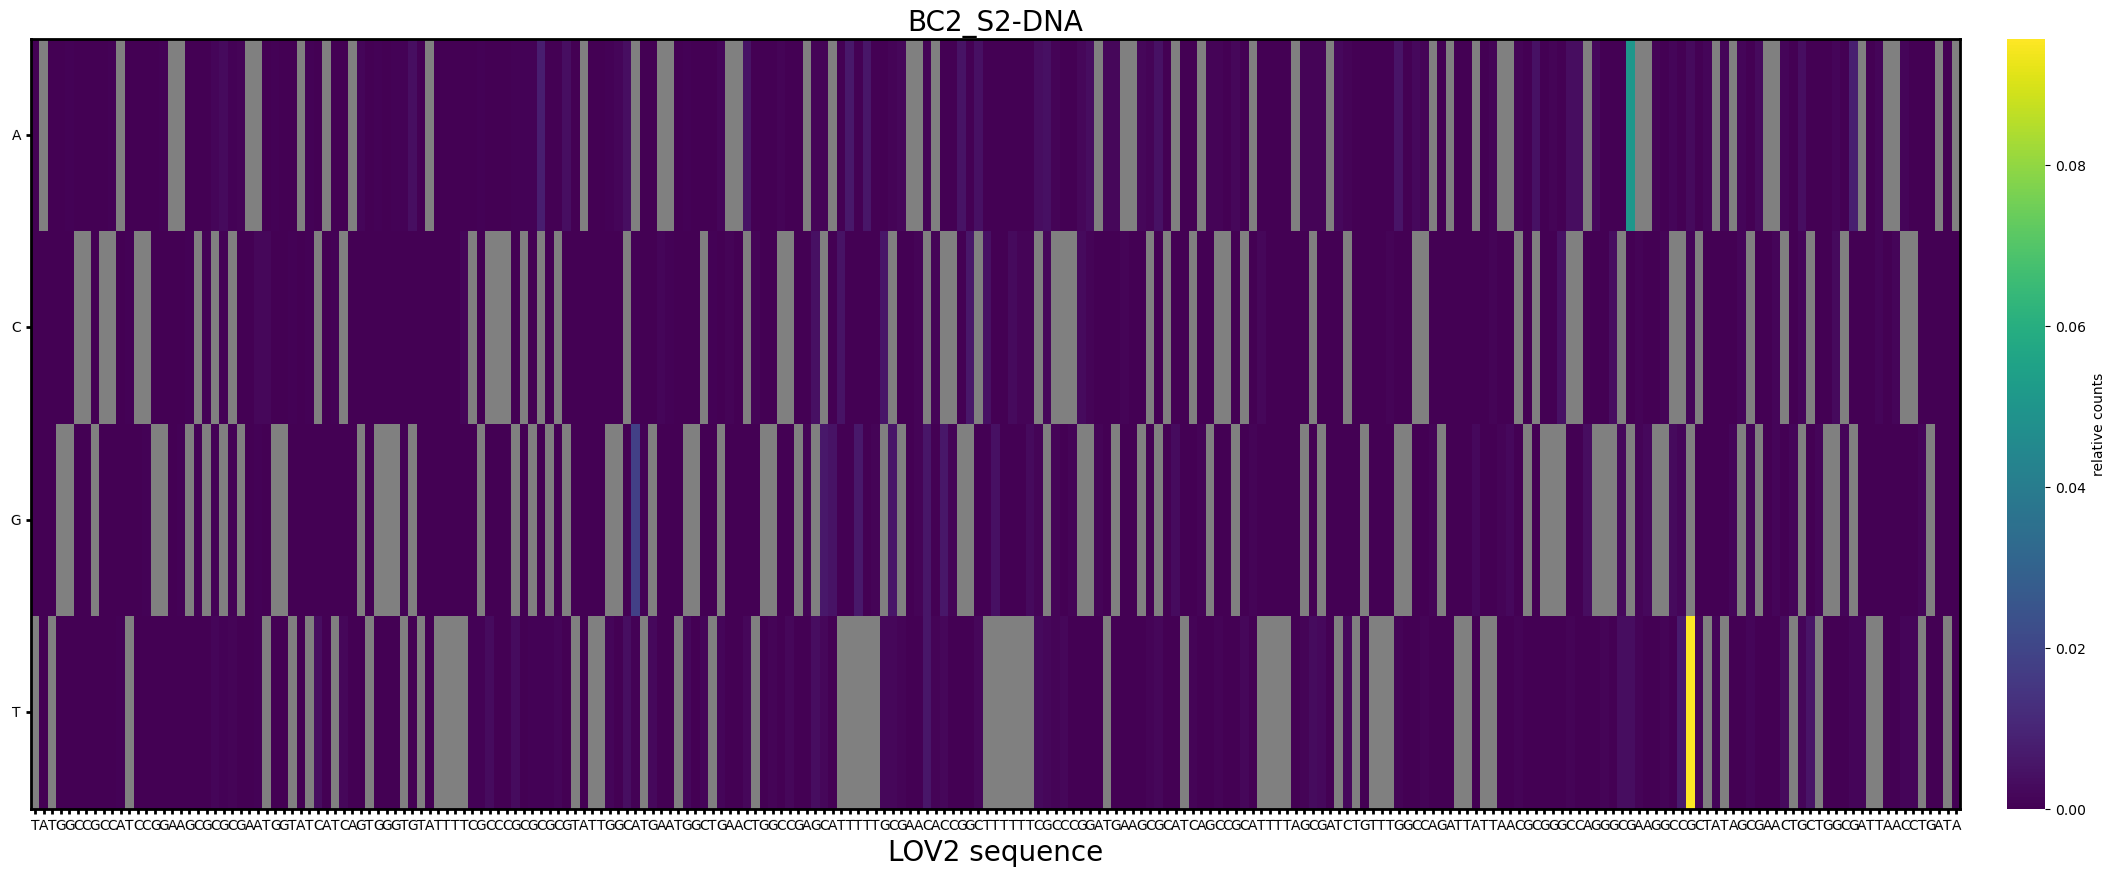

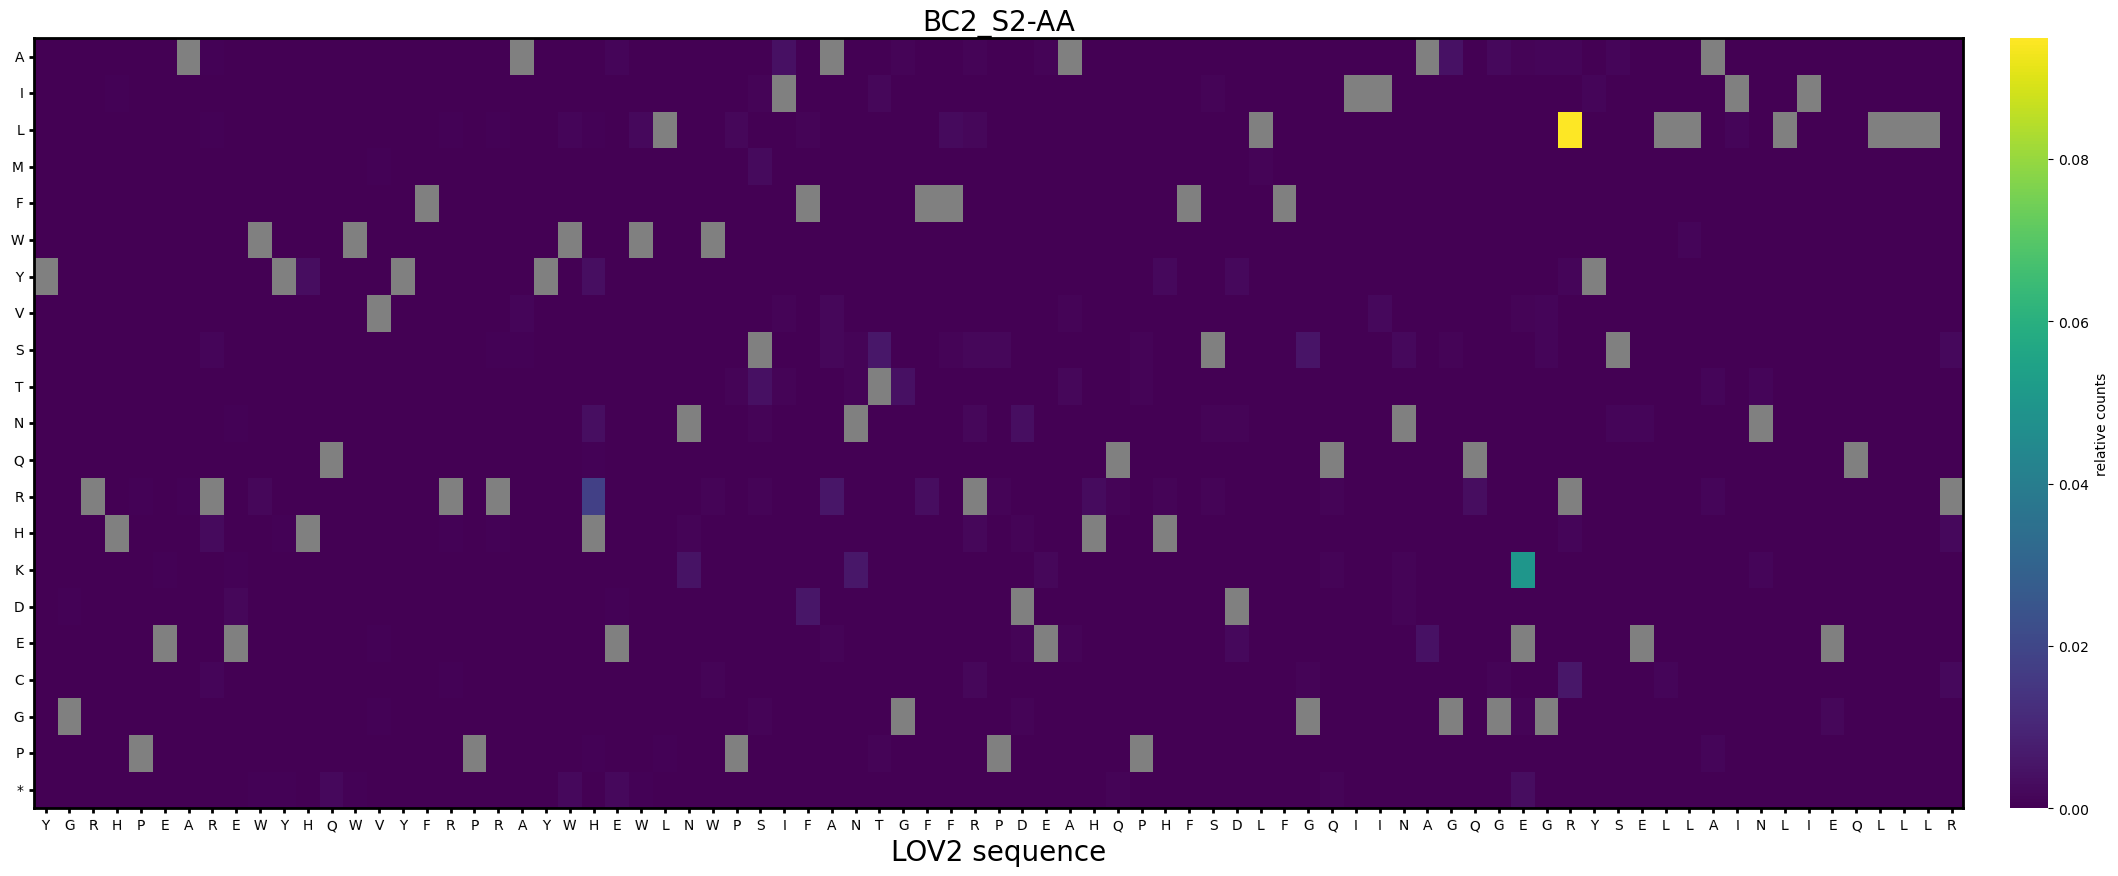

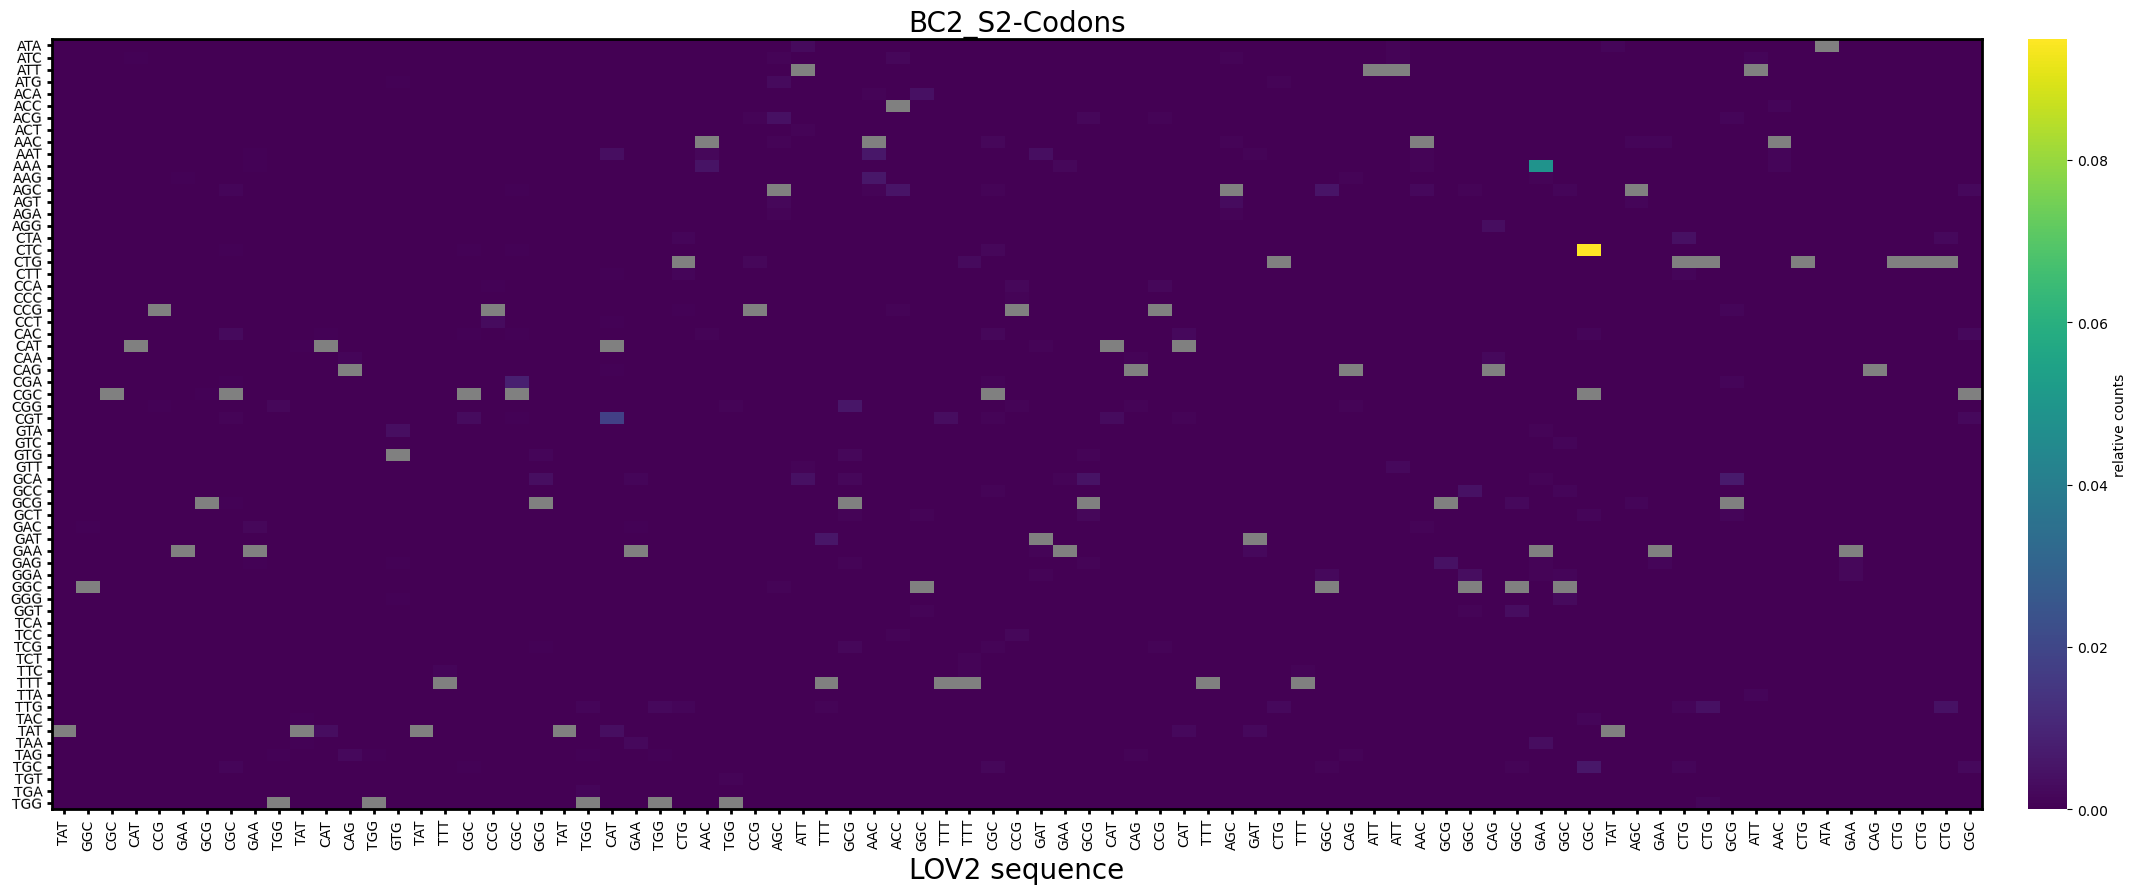

In [714]:
## plot mutation enrichment on DNA, AA and Codon level 

DNA_relative = (seq_variants['DNA']/seq_variants['DNA'].sum()).iloc[:,:225]
DNA_relative.dropna(axis = 1, inplace=True)
plot_mutation_enrichment(DNA_relative, name =  f'{name}-DNA', backward= not use_forward_read, data_type = "DNA", ref_seq=ref_seq_Section, fig_folder=FigFolder)

AA_relative = seq_variants['AA']/seq_variants['AA'].sum()
AA_relative.dropna(axis = 1, inplace=True)
plot_mutation_enrichment(AA_relative, f'{name}-AA',ref_seq=ref_prot_section,data_type = "AA", backward = not use_forward_read, fig_folder=FigFolder)

Codons_relative = seq_variants['Codons']/seq_variants['Codons'].sum()
Codons_relative.dropna(axis = 1, inplace=True)
plot_mutation_enrichment(Codons_relative, f'{name}-Codons',ref_seq=ref_seq_Section,data_type = "Codons", backward = not use_forward_read, fig_folder=FigFolder)


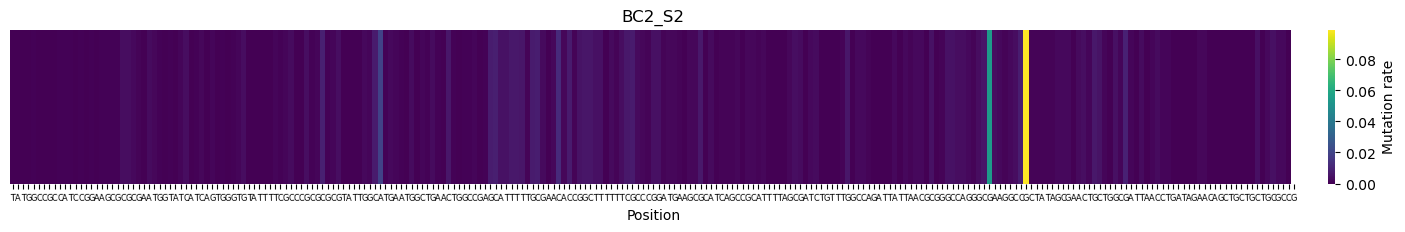

In [715]:
DNA_mut_rate_per_pos = ((seq_variants["DNA"].sum()-seq_variants["DNA"].max())/seq_variants["DNA"].sum())[:245]
plot_mut_rate_per_pos(DNA_mut_rate_per_pos, variant_name = name, FigFolder = FigFolder, ref_seq=ref_seq_Section[:245])


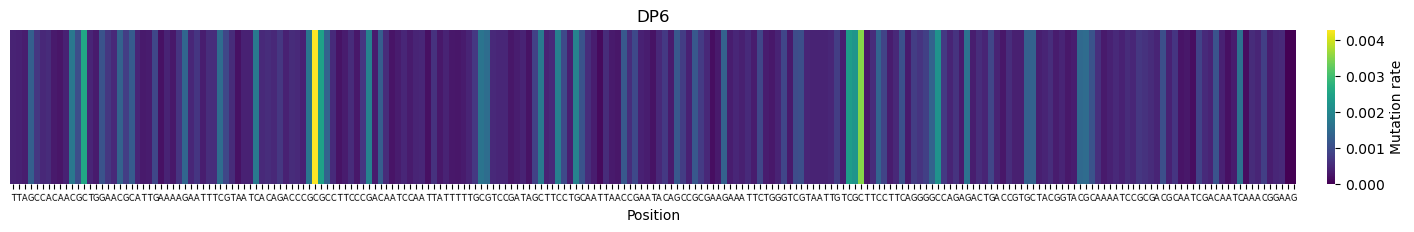

<Figure size 640x480 with 0 Axes>

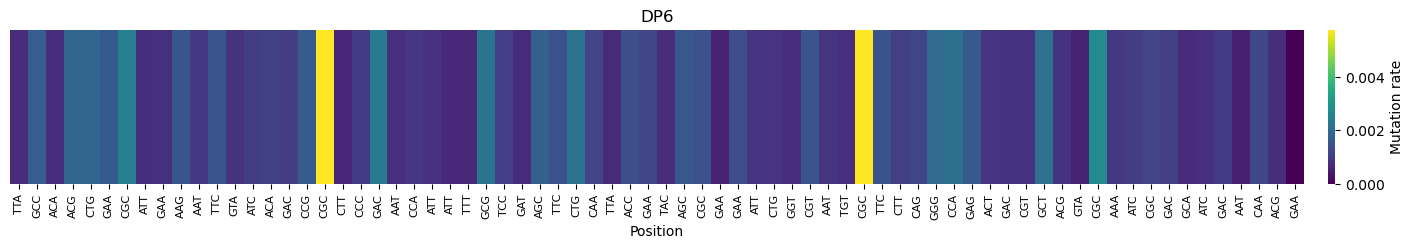

In [44]:
## plot mutation rate per position 
DNA_mut_rate_per_pos = (seq_variants["DNA"].sum()-seq_variants["DNA"].max())/seq_variants["DNA"].sum()

plot_mut_rate_per_pos(DNA_mut_rate_per_pos, variant_name = variant, FigFolder = FigFolder)

Codon_mut_rate_per_pos = Codons_relative.sum()-Codons_relative.max()
LOV_codons = [LOV_gene[i:i+3] for i in range(0, len(Codon_mut_rate_per_pos)*3, 3)]

plt.figure(figsize=(20,2))
sns.heatmap(pd.DataFrame(Codon_mut_rate_per_pos).T, cmap = "viridis", cbar = True, cbar_kws = {"pad": 0.015, "label": "Mutation rate" },linecolor="black", xticklabels=LOV_codons, yticklabels=False)
plt.xlabel("Position")
plt.xticks(fontsize=8)
plt.title(name)
#plt.savefig(f"{FigFolder}/{name}_mutation_rate_per_Codon_position.pdf", bbox_inches = "tight")
plt.show()
plt.clf()

In [6]:
Section = "S1"
Bc = "BC1"
tripl_st = Primer_out_of_triplets[Section+"_fwd_primer"]
tripl_end = Primer_out_of_triplets[Section+"_rev_primer"]
ref_seq_Section = ref_gene[ref_gene.index(Primer_seq[Section + "_fwd_primer"][tripl_st:]):ref_gene.index(dna_rev_comp(Primer_seq[Section+"_rev_primer"][tripl_end:]))+len(Primer_seq[Section+"_rev_primer"][tripl_end:])]
ref_prot_section = translate_dna2aa(ref_seq_Section)

seq_variants = get_variants(all_reads[f"Mutagenesis_{Bc}_{Section}_R1"], all_reads[f"Mutagenesis_{Bc}_{Section}_R2"], catch_left=Barcodes[f"{Bc}_Fwd"]+Primer_seq[Section + "_fwd_primer"][:tripl_st],catch_right=dna_rev_comp(Barcodes[f"{Bc}_Rev"]+Primer_seq[Section+"_rev_primer"][:tripl_end]), ref_prot = ref_prot_section, ref_gene = ref_seq_Section, use_forward_read=True, use_backward_read=False, codons = codons)

In [8]:
ref_gene

'GGCGCAACTATCGGTATCAAGCTGTTTAAGAAATTCACCTCGAAAGCAAGTTGATAAACTGATACAATTAAAGGCTCCTTTTGGAGCCTTTTTTTTTGGAGTAAGGAGGAAAAATGTCCGAGGAAGCGCAGAACGATCCGCTGCTGCCGGGCTATAGCTTTAACGCGCATCTGGTGGCGGGCCTGACCCCGATTGAAGCGAACGGCTATCTGGATTTTTTTATTGATCGCCCGCTGGGCATGAAAGGCTATATTCTGAACCTGACCATTCGCGGCCAGGGCGTGGTGAAAAACCAGGGCCGCGAATTTGTGTGCCGCCCGGGCGATATTCTGCTGTTTCCGCCGGGCGAAATTCATCATTATGGCCGCCATCCGGAAGCGCGCGAATGGTATCATCAGTGGGTGTATTTTCGCCCGCGCGCGTATTGGCATGAATGGCTGAACTGGCCGAGCATTTTTGCGAACACCGGCTTTTTTCGCCCGGATGAAGCGCATCAGCCGCATTTTAGCGATCTGTTTGGCCAGATTATTAACGCGGGCCAGGGCGAAGGCCGCTATAGCGAACTGCTGGCGATTAACCTGATAGAACAGCTGCTGCTGCGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGC

In [20]:
# mutagenic spectrum
Sections = ["S1", "S2", "S3", "S4"]
Bc = "BC1"

overall_mut_spectrum =pd.DataFrame(index=["A", "C", "G", "T"], columns=["A", "C", "G", "T"], data = 0)
combined_ref_sections = []


for Section in Sections: 
    tripl_st = Primer_out_of_triplets[Section+"_fwd_primer"]
    tripl_end = Primer_out_of_triplets[Section+"_rev_primer"]
    ref_seq_Section = ref_gene[ref_gene.index(Primer_seq[Section + "_fwd_primer"][tripl_st:]):ref_gene.index(dna_rev_comp(Primer_seq[Section+"_rev_primer"][tripl_end:]))+len(Primer_seq[Section+"_rev_primer"][tripl_end:])]
    n_mut_spectrum, n_mut_spectrum_perc  = mut_spectrum(all_reads[f"Mutagenesis_{Bc}_{Section}_R1"], all_reads[f"Mutagenesis_{Bc}_{Section}_R2"], catch_left=Barcodes[f"{Bc}_Fwd"]+Primer_seq[Section + "_fwd_primer"][:tripl_st],catch_right=dna_rev_comp(Barcodes[f"{Bc}_Rev"]+Primer_seq[Section+"_rev_primer"][:tripl_end]),use_backward_read=False,use_forward_read=True, reference_seq=ref_seq_Section)

    print(pd.DataFrame.from_dict(n_mut_spectrum, orient='index', dtype = "float"))

    overall_mut_spectrum += pd.DataFrame.from_dict(n_mut_spectrum, orient='index', dtype = "float")
    combined_ref_sections.append(ref_seq_Section)

print(overall_mut_spectrum)
overall_mut_spectrum_perc = overall_mut_spectrum/overall_mut_spectrum.sum().sum()*100

np.fill_diagonal(overall_mut_spectrum_perc.values, np.nan) # set diagonal (= filled with zeros, since this is no mutation) to NA (for plotting)
np.fill_diagonal(overall_mut_spectrum.values, np.nan)




       A      C     G      T
A    0.0  159.0  92.0   67.0
C   67.0    0.0  21.0  117.0
G  118.0   19.0   0.0  194.0
T   44.0   64.0  45.0    0.0
      A      C     G      T
A   0.0  158.0  61.0   18.0
C  63.0    0.0  27.0  110.0
G  95.0   43.0   0.0  146.0
T  28.0   83.0  28.0    0.0
       A      C     G      T
A    0.0   60.0  66.0   63.0
C   90.0    0.0  21.0  167.0
G  136.0   36.0   0.0  168.0
T   47.0  106.0  34.0    0.0
       A      C      G      T
A    0.0  202.0   58.0  115.0
C  160.0    0.0   21.0  237.0
G  332.0   78.0    0.0  418.0
T   31.0  109.0  109.0    0.0
       A      C      G      T
A    0.0  579.0  277.0  263.0
C  380.0    0.0   90.0  631.0
G  681.0  176.0    0.0  926.0
T  150.0  362.0  216.0    0.0


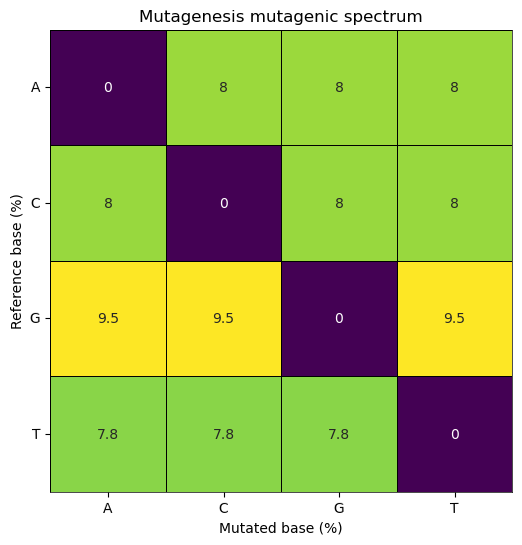

<Figure size 640x480 with 0 Axes>

In [21]:
## expected mut spectrum
combined_ref_sections = "".join(combined_ref_sections)
mut_spec_expected = {"A": {"A":0, "C":0, "G":0, "T":0}, ## {reference nt: {mutated nt: count}}
                    "C" : {"A":0, "C":0, "G":0, "T":0},
                    "G" : {"A":0, "C":0, "G":0, "T":0},
                    "T" : {"A":0, "C":0, "G":0, "T":0}}
for ref_nt in combined_ref_sections:
    for mut_nt in ["A", "C", "G", "T"]:
        if ref_nt != mut_nt:
        ## calculate mutagenic spectrum for all expected changes per Nt
            mut_spec_expected[ref_nt][mut_nt] += 1

mut_spec_expected = pd.DataFrame.from_dict(mut_spec_expected, orient='index', dtype = "float")
mut_spec_expected_perc = mut_spec_expected/mut_spec_expected.sum().sum()*100

plot_mutation_spectrum(mut_spec_expected_perc, samplename = "Mutagenesis", fig_folder = None, colormap = "viridis")

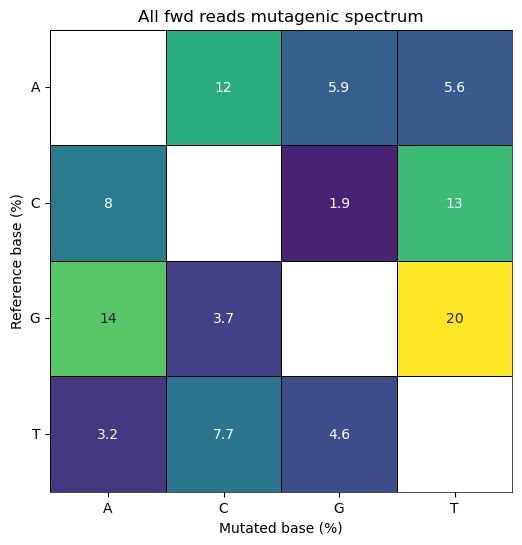

<Figure size 640x480 with 0 Axes>

In [49]:
plot_mutation_spectrum(overall_mut_spectrum_perc,samplename = "All fwd reads",  fig_folder = "output/PACE")

In [32]:
## Look for coocurrence of mutations in the same read (choose positive selection cylce 3)
## specifically E144K and R146L mutations
## is in Section 2
Section = "S2" 
Bc = "BC4"
read_of_interest = all_reads[f"NegPosSelection_{Bc}_{Section}_R1"] ## fwd read section 2 pos selection cycle 3
region = "ISVLS" 
region = "QGEGR"

## find the positions of the mutations

tripl_st = Primer_out_of_triplets[Section+"_fwd_primer"]
ref_gene_section = find_reference_seq(ref_gene = R5_Pool_seq, Primer_seq = Primer_seq, Section = Section, Primer_out_of_triplets = Primer_out_of_triplets)
ref_protein_section = translate_dna2aa(ref_gene_section)

catch_left = Barcodes[f"{Bc}_Fwd"]+Primer_seq[Section + "_fwd_primer"][:tripl_st]
AA_seqs = [translate_dna2aa(dna[dna.index(catch_left)+len(catch_left):]) for dna in read_of_interest if catch_left in dna]

index_of_interest = ref_protein_section.index(region)
sections_of_interest = [AA_seq[index_of_interest:index_of_interest+len(region)] for AA_seq in AA_seqs] 
sections_of_interest = [sec for sec in sections_of_interest if len(sec)==len(region)]## keep only those that have the region of interest

## find occurences of mutations
coocurrence = {}
for sec in sections_of_interest:
    if sec[2:] not in coocurrence:
        coocurrence[sec[2:]] = 1
    else: 
        coocurrence[sec[2:]] += 1

## order coocurrence after value size
coocurrence = dict(sorted(coocurrence.items(), key=lambda item: item[1], reverse=True))

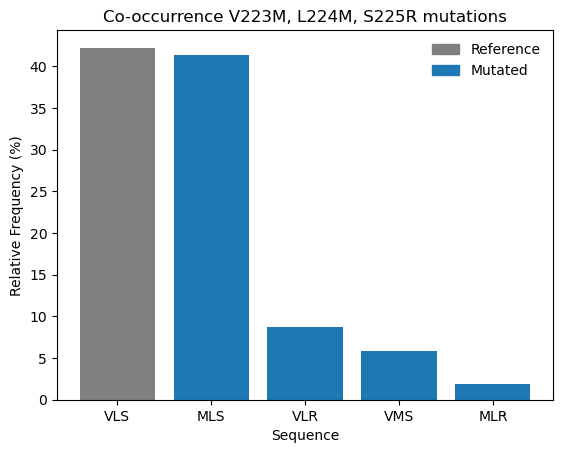

In [30]:
colors = ["grey" if key == region[2:] else "tab:blue" for key in coocurrence.keys()]
coocurrence_perc = {key: val/sum(coocurrence.values())*100 for key, val in coocurrence.items()}
plt.bar(coocurrence_perc.keys(), coocurrence_perc.values(), color = colors, )
## set color of reference as grey
plt.title("Co-occurrence V223M, L224M, S225R mutations")
plt.ylabel("Relative Frequency (%)")
plt.xlabel("Sequence")
## add legend
grey_patch = mpatches.Patch(color='grey', label='Reference')
blue_patch = mpatches.Patch(color='tab:blue', label='Mutated')
plt.legend(handles=[grey_patch, blue_patch], frameon = False)
plt.savefig("output/PACE/mutation_cooccurrence/Cooccurence_V223M_L224M_S225R.pdf")

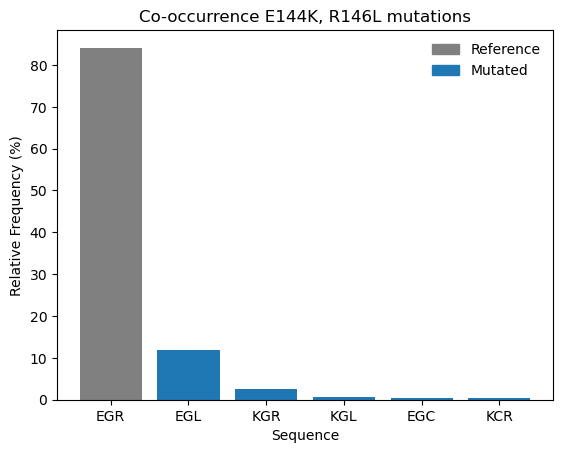

In [36]:
colors = ["grey" if key == region[2:] else "tab:blue" for key in coocurrence.keys()]
coocurrence_perc = {key: val/sum(coocurrence.values())*100 for key, val in coocurrence.items()}
plt.bar(coocurrence_perc.keys(), coocurrence_perc.values(), color = colors, )
## set color of reference as grey

plt.title("Co-occurrence E144K, R146L mutations")
plt.ylabel("Relative Frequency (%)")
plt.xlabel("Sequence")
## add legend
grey_patch = mpatches.Patch(color='grey', label='Reference')
blue_patch = mpatches.Patch(color='tab:blue', label='Mutated')
plt.legend(handles=[grey_patch, blue_patch], frameon = False)
plt.savefig("output/PACE/mutation_cooccurrence/Cooocurrence_E144K_R146L.pdf")

In [712]:
mut_spec_codons, mut_spectrum_codons_perc =  mut_spectrum_codons(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read = False, use_forward_read = True, codon_list = codons, treshold = 10)
mut_spectrum_codons_perc_df = pd.DataFrame.from_dict(mut_spectrum_codons_perc, orient='index')
np.fill_diagonal(mut_spectrum_codons_perc_df.values, np.nan)

In [713]:
mut_spectrum_codons_df = pd.DataFrame.from_dict(mut_spec_codons, orient='index')
mut_spectrum_codons_df.sum().sum()

np.int64(8466)

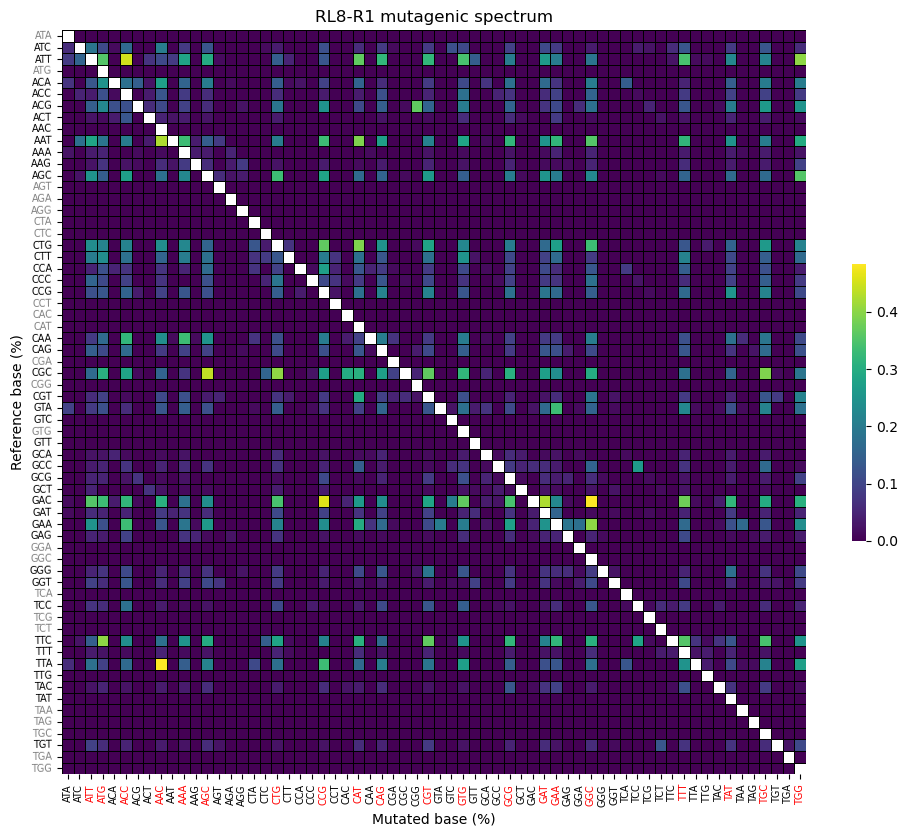

In [716]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(mut_spectrum_codons_perc_df, annot=False, linewidths=.5, ax=ax,  cbar = True, square = True, linecolor = "black", cmap = "viridis", cbar_kws={'shrink': 0.3},  xticklabels=True)
plt.xlabel('Mutated base (%)', fontsize = 10)
plt.ylabel('Reference base (%)', fontsize = 10)
# for _, spine in ax.spines.items():
#     spine.set_visible(True)
#     spine.set_linewidth(.5)
#ax.set_facecolor('gray')
ax.set_yticklabels(ax.get_yticklabels(), rotation=1, fontsize=7)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)

for i, tick_label in enumerate(ax.get_xticklabels()):
    if tick_label.get_text() in ecoli_pref.values():
        tick_label.set_color('red')

for i, tick_label in enumerate(ax.get_yticklabels()):
    if tick_label.get_text() not in ref_codons:
        tick_label.set_color('grey')

plt.title(f"{name} mutagenic spectrum", fontsize = 12)
plt.savefig(f"{FigFolder}/{name}_mutagenic_spectrum_codons_perc.pdf")
plt.show()

In [717]:
### calculate expected mutagenic spectrum for RL8 (--> bias because of chosen Codons for AAs) (for R1 reads only)
## Codon wise
variant = "RL8"
name = "RL8-R1"
a_seq, b_seq = read_sequences(variant)
FigFolder = f"{base_dir}/figures/{name}"
max_len_R1 = max([len(seq) for seq in a_seq])
ref_seq = LOV_gene[:max_len_R1]
ref_codons = [ref_seq[i:i+3] for i in range(0, len(ref_seq)//3*3, 3)]
mut_spec_expected = {"A": {"A":0, "C":0, "G":0, "T":0}, ## {reference nt: {mutated nt: count}}
                    "C" : {"A":0, "C":0, "G":0, "T":0},
                    "G" : {"A":0, "C":0, "G":0, "T":0},
                    "T" : {"A":0, "C":0, "G":0, "T":0}}
for ref_codon in ref_codons:
    for mut_codon in ecoli_pref.values():
        ## calculate mutagenic spectrum for all expected changes per Codon
        for idx in range(3):
            if ref_codon[idx] != mut_codon[idx]:
                mut_spec_expected[ref_codon[idx]][mut_codon[idx]] += 1
        

## calculate mutagenic spectrum in percentage
total_n_muts = sum([sum(value.values()) for value in mut_spec_expected.values()])
mut_spec_expected_perc = {ref_base: {mut_base: round(val/total_n_muts*100, 3) for mut_base, val in value.items()} for ref_base, value in mut_spec_expected.items()}
        

total reads 47233


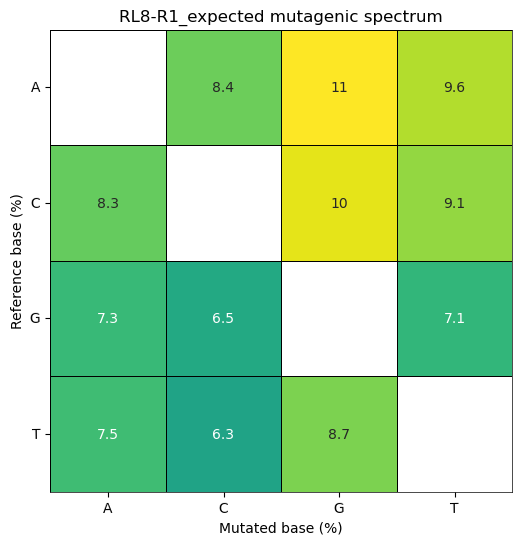

In [457]:
mut_spec_expected_perc_df = pd.DataFrame.from_dict(mut_spec_expected_perc, orient = "index")
np.fill_diagonal(mut_spec_expected_perc_df.values, np.nan)
plot_mutation_spectrum(pd.DataFrame.from_dict(mut_spec_expected_perc_df), samplename = f"{name}_expected", fig_folder = FigFolder)

In [718]:
_, n_mut_spectrum_perc  = mut_spectrum(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read=use_backward_read, use_forward_read=use_forward_read, treshold=10)

n_mut_spectrum_perc_df = pd.DataFrame.from_dict(n_mut_spectrum_perc, orient='index')


np.fill_diagonal(n_mut_spectrum_perc_df.values, np.nan) # set diagonal (= filled with zeros, since this is no mutation) to NA (for plotting)

mut_spec_expected_vs_observed = mut_spec_expected_perc_df - n_mut_spectrum_perc_df

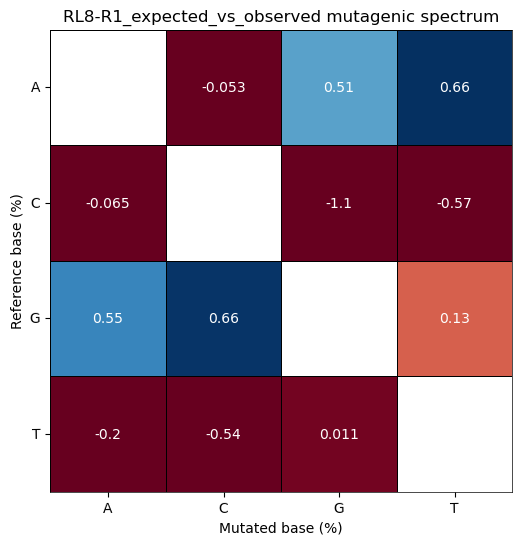

In [719]:
plot_mutation_spectrum(mut_spec_expected_vs_observed, samplename = f"{name}_expected_vs_observed", fig_folder = FigFolder, colormap = "RdBu")

In [720]:
### calculate expected Codon mutagenic spectrum for RL8 (--> bias because of chosen Codons for AAs) (for R1 reads only)

## Codon wise
variant = "RL8"
name = "RL8-R1"
a_seq, b_seq = read_sequences(variant)
FigFolder = f"{base_dir}/figures/{name}"
max_len_R1 = max([len(seq) for seq in a_seq])
ref_seq = LOV_gene[:max_len_R1]
ref_codons = [ref_seq[i:i+3] for i in range(0, len(ref_seq)//3*3, 3)]
codon_list = codons

Codon_mut_spec_expected = {ref_codon: {codon:0 for codon in codon_list} for ref_codon in codon_list} # reference_codon : {mutated_codon: count}

for ref_codon in ref_codons:
    for mut_codon in ecoli_pref.values():
        ## calculate mutagenic spectrum for all expected codons per codon
            if ref_codon != mut_codon:
                Codon_mut_spec_expected[ref_codon][mut_codon] += 1
        

## calculate mutagenic spectrum in percentage
total_n_muts = sum([sum(value.values()) for value in Codon_mut_spec_expected.values()])
Codon_mut_spec_expected_perc = {ref_base: {mut_base: round(val/total_n_muts*100, 3) for mut_base, val in value.items()} for ref_base, value in Codon_mut_spec_expected.items()}



total reads 47233


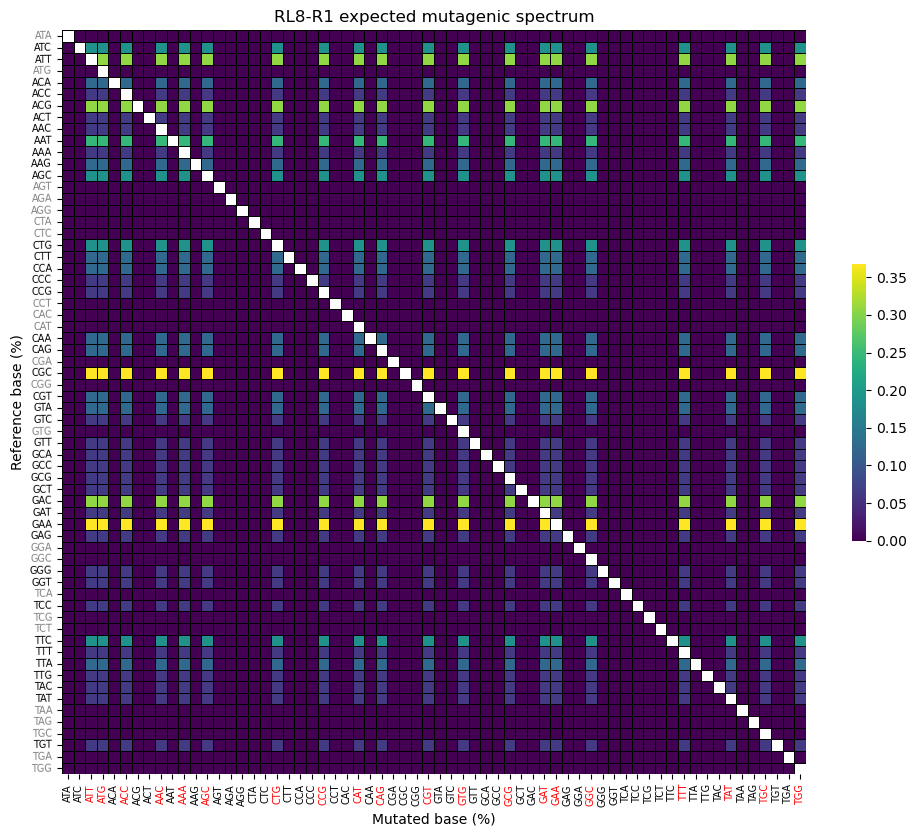

In [722]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(Codon_mut_spec_expected_perc_df, annot=False, linewidths=.5, ax=ax,  cbar = True, square = True, linecolor = "black", cmap = "viridis", cbar_kws={'shrink': 0.3},  xticklabels=True)
plt.xlabel('Mutated base (%)', fontsize = 10)
plt.ylabel('Reference base (%)', fontsize = 10)
# for _, spine in ax.spines.items():
#     spine.set_visible(True)
#     spine.set_linewidth(.5)
#ax.set_facecolor('gray')
ax.set_yticklabels(ax.get_yticklabels(), rotation=1, fontsize=7)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)

for i, tick_label in enumerate(ax.get_xticklabels()):
    if tick_label.get_text() in ecoli_pref.values():
        tick_label.set_color('red')

for i, tick_label in enumerate(ax.get_yticklabels()):
    if tick_label.get_text() not in ref_codons:
        tick_label.set_color('grey')

plt.title(f"{name} expected mutagenic spectrum", fontsize = 12)
plt.savefig(f"{FigFolder}/{name}_expected_mutagenic_spectrum_codons_perc.pdf")
plt.show()

In [723]:
mut_spec_codons, mut_spectrum_codons_perc =  mut_spectrum_codons(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read = False, use_forward_read = True, codon_list = codons, treshold = 6)
mut_spectrum_codons_perc_df = pd.DataFrame.from_dict(mut_spectrum_codons_perc, orient='index')
np.fill_diagonal(mut_spectrum_codons_perc_df.values, np.nan)

mut_spectrum_codons_expected_vs_observed = Codon_mut_spec_expected_perc_df - mut_spectrum_codons_perc_df

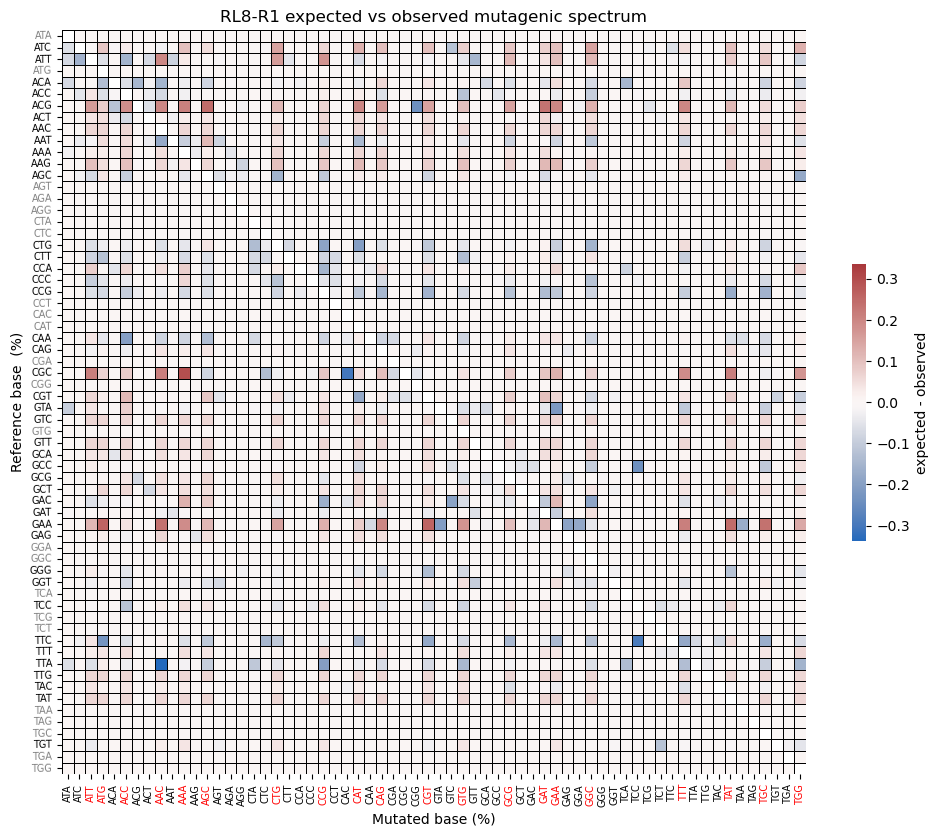

In [725]:
f, ax = plt.subplots(figsize=(12, 12))
cmap_max = np.max(abs(mut_spectrum_codons_expected_vs_observed))
sns.heatmap(mut_spectrum_codons_expected_vs_observed, annot=False, linewidths=.5, ax=ax,  cbar = True, square = True, linecolor = "black", cmap = "vlag",vmin = -cmap_max, vmax = cmap_max ,cbar_kws={'shrink': 0.3, "label" : "expected - observed"},  xticklabels=True)
plt.xlabel('Mutated base (%)', fontsize = 10)
plt.ylabel('Reference base  (%)', fontsize = 10)
# for _, spine in ax.spines.items():
#     spine.set_visible(True)
#     spine.set_linewidth(.5)
#ax.set_facecolor('gray')
ax.set_yticklabels(ax.get_yticklabels(), rotation=1, fontsize=7)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)

for i, tick_label in enumerate(ax.get_xticklabels()):
    if tick_label.get_text() in ecoli_pref.values():
        tick_label.set_color('red')


for i, tick_label in enumerate(ax.get_yticklabels()):
    if tick_label.get_text() not in ref_codons:
        tick_label.set_color('grey')

plt.title(f"{name} expected vs observed mutagenic spectrum", fontsize = 12)
plt.savefig(f"{FigFolder}/{name}_expected_vs_observed_mutagenic_spectrum_codons_perc.pdf")
plt.show()

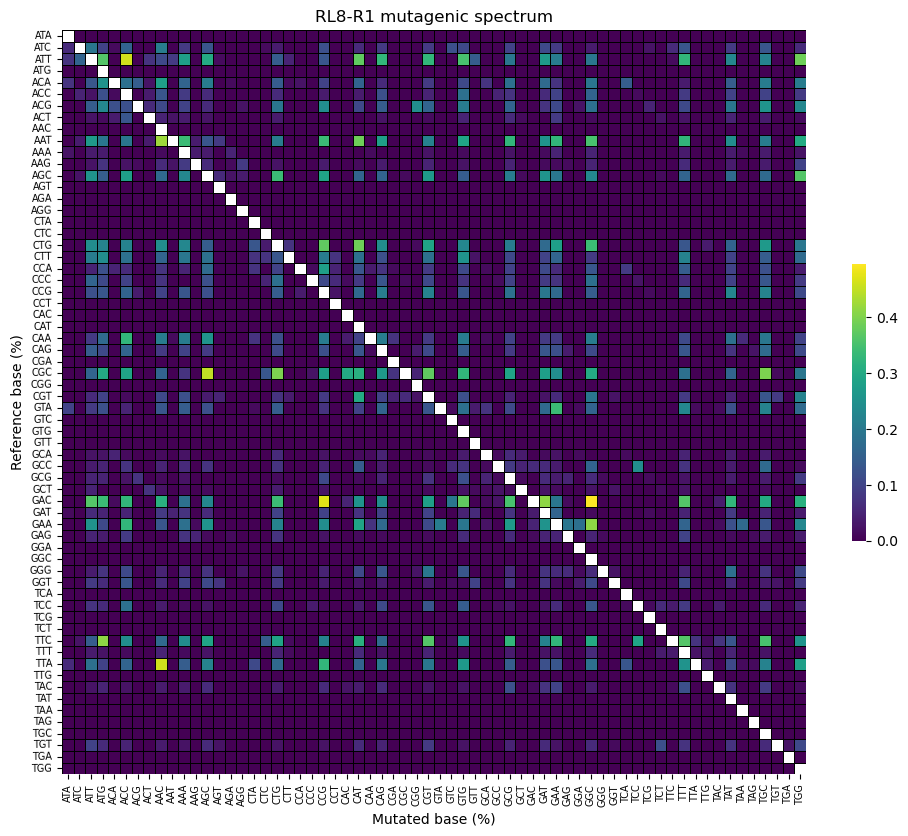

In [726]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(mut_spectrum_codons_perc_df, annot=False, linewidths=.5, ax=ax, vmin = 0, cbar = True, square = True, linecolor = "black", cmap = "viridis", cbar_kws={'shrink': 0.3},  xticklabels=True)
plt.xlabel('Mutated base (%)', fontsize = 10)
plt.ylabel('Reference base (%)', fontsize = 10)
# for _, spine in ax.spines.items():
#     spine.set_visible(True)
#     spine.set_linewidth(.5)
#ax.set_facecolor('gray')
ax.set_yticklabels(ax.get_yticklabels(), rotation=1, fontsize=7)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)

# for i, tick_label in enumerate(ax.get_xticklabels()):
#     if tick_label.get_text() in ecoli_pref.values():
#         tick_label.set_color('red')

plt.title(f"{name} mutagenic spectrum", fontsize = 12)
plt.savefig(f"{FigFolder}/{name}_mutagenic_spectrum_codons_perc.pdf")
plt.show()

In [727]:
## calculate number of single/double/triple Nt changes codon-wise
Codon_vars = seq_variants["Codons"]
LOV_codons = [LOV_gene[i:i+3] for i in range(0, Codon_vars.shape[1]*3, 3)]

Nt_changes = {1:0, 2:0, 3:0} # single,double,triple Nt mutations within codons
for pos, mut_Codons in Codon_vars.items(): # iterate columnwise over DF with counts of mutated Codons
    ref_codon = LOV_codons[pos]
    for mut_codon in mut_Codons.index:
        if mut_codon != ref_codon: 
            n_changes = sum([ref_codon[i] != mut_codon[i] for i in range(3)]) # count number of nt changes within the codon
            Nt_changes[n_changes] += mut_Codons[mut_codon] # add the count of the mutated codon to the respective category

relative_Nt_changes_observed = {key: val/sum(Nt_changes.values()) for key,val in Nt_changes.items()}
        

In [728]:
## calculate expected number of single/double/triple Nt changes codon-wise
expected_Nt_changes = {1:0, 2:0, 3:0}

for ref_Codon in LOV_codons: 
    for mut_Codon in ecoli_pref.values(): 
        if mut_Codon != ref_Codon: 
            n_changes = sum([ref_Codon[i] != mut_Codon[i] for i in range(3)])
            expected_Nt_changes[n_changes] += 1

relative_expected_Nt_changes = {key: val/sum(expected_Nt_changes.values()) for key, val in expected_Nt_changes.items()}

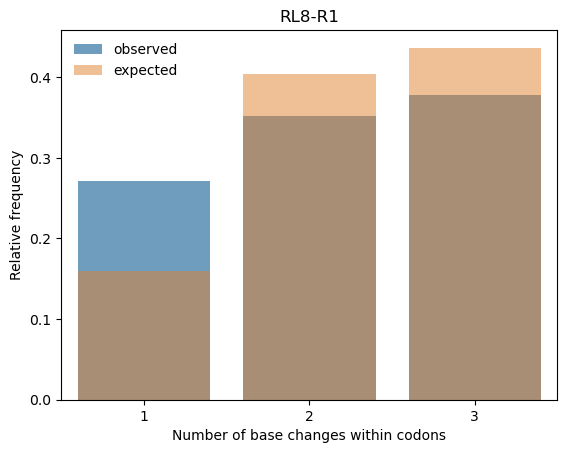

In [729]:
sns.barplot(relative_Nt_changes_observed, alpha = 0.7, label = "observed")
sns.barplot(relative_expected_Nt_changes, alpha = 0.5, label = "expected")
plt.legend(frameon = False)
plt.xlabel("Number of base changes within codons")
plt.ylabel("Relative frequency")
plt.title("RL8-R1")
plt.savefig(f"{FigFolder}/{variant}_base_changes_per_codon_exp_vs_obs.pdf")
plt.show()

In [750]:
Codon_base_bias = {key: obs/relative_expected_Nt_changes[key] for key, obs in relative_Nt_changes_observed.items()}

In [751]:
Codon_base_bias

{1: np.float64(1.7006407340123402),
 2: np.float64(0.8700318515441074),
 3: np.float64(0.8643298213964781)}

In [759]:
### use relative_Nt_changes_observed as background model 
### build background matrix
background_matrix = pd.DataFrame(0.0, index = mut_spectrum_codons_expected_vs_observed.index, columns = mut_spectrum_codons_expected_vs_observed.columns)
for ref_codon in background_matrix.index: 
    for mut_codon in background_matrix.columns: 
        if ref_codon != mut_codon:
            n_changes = sum([ref_codon[i] != mut_codon[i] for i in range(3)])
            background_matrix.loc[ref_codon, mut_codon] = Codon_base_bias[n_changes]

background_exp_matrix = pd.DataFrame(0.0, index = mut_spectrum_codons_expected_vs_observed.index, columns = mut_spectrum_codons_expected_vs_observed.columns)
for ref_codon in background_exp_matrix.index: 
    for mut_codon in background_exp_matrix.columns: 
        if ref_codon != mut_codon:
            n_changes = sum([ref_codon[i] != mut_codon[i] for i in range(3)])
            background_exp_matrix.loc[ref_codon, mut_codon] = relative_expected_Nt_changes[n_changes]

In [760]:
likelihood_model = mut_spectrum_codons_perc_df/background_matrix
likelihood_perc = likelihood_model/likelihood_model.sum().sum()*100
#likelihood_exp = Codon_mut_spec_expected_perc_df/background_exp_matrix
#likelihood_exp_perc = likelihood_exp/likelihood_exp.sum().sum()*100
exp_vs_obs =  Codon_mut_spec_expected_perc_df - likelihood_perc

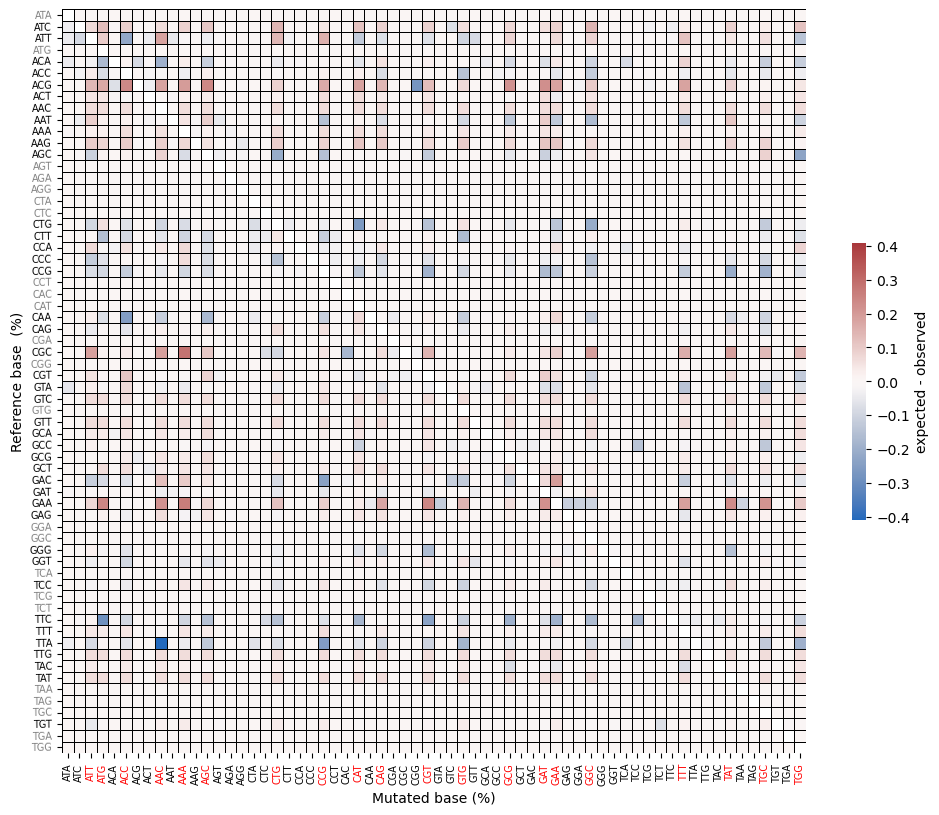

In [761]:
f, ax = plt.subplots(figsize=(12, 12))
cmap_max = np.max(abs(exp_vs_obs))
sns.heatmap(exp_vs_obs, annot=False, linewidths=.5, ax=ax,  cbar = True, square = True, linecolor = "black", cmap = "vlag",vmin = -cmap_max, vmax = cmap_max ,cbar_kws={'shrink': 0.3, "label" : "expected - observed"},  xticklabels=True)
plt.xlabel('Mutated base (%)', fontsize = 10)
plt.ylabel('Reference base  (%)', fontsize = 10)
# for _, spine in ax.spines.items():
#     spine.set_visible(True)
#     spine.set_linewidth(.5)
#ax.set_facecolor('gray')
ax.set_yticklabels(ax.get_yticklabels(), rotation=1, fontsize=7)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)

for i, tick_label in enumerate(ax.get_xticklabels()):
    if tick_label.get_text() in ecoli_pref.values():
        tick_label.set_color('red')


for i, tick_label in enumerate(ax.get_yticklabels()):
    if tick_label.get_text() not in ref_codons:
        tick_label.set_color('grey')

# plt.title(f"{name} expected vs observed mutagenic spectrum", fontsize = 12)
# plt.savefig(f"{FigFolder}/{name}_expected_vs_observed_mutagenic_spectrum_codons_perc.pdf")
plt.show()

In [677]:
Codon_mut_spec_expected_perc_df

,ATA,ATC,ATT,ATG,ACA,ACC,ACG,ACT,AAC,AAT,...,TTA,TTG,TAC,TAT,TAA,TAG,TGC,TGT,TGA,TGG
ATA,NaN,0.0,0.000,0.000,0.0,0.000,0.0,0.0,0.000,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000
ATC,0.0,NaN,0.184,0.184,0.0,0.184,0.0,0.0,0.184,0.0,...,0.0,0.0,0.0,0.184,0.0,0.0,0.184,0.0,0.0,0.184
ATT,0.0,0.0,NaN,0.307,0.0,0.307,0.0,0.0,0.307,0.0,...,0.0,0.0,0.0,0.307,0.0,0.0,0.307,0.0,0.0,0.307
ATG,0.0,0.0,0.000,NaN,0.0,0.000,0.0,0.0,0.000,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000
ACA,0.0,0.0,0.123,0.123,NaN,0.123,0.0,0.0,0.123,0.0,...,0.0,0.0,0.0,0.123,0.0,0.0,0.123,0.0,0.0,0.123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TAG,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.0,0.000,0.0,...,0.0,0.0,0.0,0.000,0.0,NaN,0.000,0.0,0.0,0.000
TGC,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.0,0.000,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,NaN,0.0,0.0,0.000
TGT,0.0,0.0,0.061,0.061,0.0,0.061,0.0,0.0,0.061,0.0,...,0.0,0.0,0.0,0.061,0.0,0.0,0.061,NaN,0.0,0.061
TGA,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.0,0.000,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,NaN,0.000


In [664]:
mut_spectrum_codons_perc_df

,ATA,ATC,ATT,ATG,ACA,ACC,ACG,ACT,AAC,AAT,...,TTA,TTG,TAC,TAT,TAA,TAG,TGC,TGT,TGA,TGG
ATA,NaN,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,...,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.000,0.000
ATC,0.610,NaN,1.335,0.019,0.0,0.305,0.0,0.000,0.019,0.038,...,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.000,0.000
ATT,0.191,0.686,NaN,0.248,0.0,0.000,0.0,0.572,0.000,0.362,...,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.000,0.000
ATG,0.000,0.000,0.000,NaN,0.0,0.000,0.0,0.000,0.000,0.000,...,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.000,0.000
ACA,0.458,0.000,0.000,0.000,NaN,0.076,0.4,0.057,0.000,0.000,...,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TAG,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,...,0.0,0.0,0.0,0.000,0.0,NaN,0.000,0.0,0.000,0.000
TGC,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,...,0.0,0.0,0.0,0.000,0.0,0.0,NaN,0.0,0.000,0.000
TGT,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,...,0.0,0.0,0.0,0.362,0.0,0.0,0.095,NaN,0.076,0.019
TGA,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,...,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,NaN,0.000


In [663]:
likelihood_model

,ATA,ATC,ATT,ATG,ACA,ACC,ACG,ACT,AAC,AAT,...,TTA,TTG,TAC,TAT,TAA,TAG,TGC,TGT,TGA,TGG
ATA,NaN,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
ATC,2.249242,NaN,4.922522,0.070058,0.0,1.124621,0.000000,0.000000,0.070058,0.108137,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
ATT,0.704271,2.529476,NaN,0.914446,0.0,0.000000,0.000000,2.109125,0.000000,1.334796,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
ATG,0.000000,0.000000,0.000000,NaN,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
ACA,1.688775,0.000000,0.000000,0.000000,NaN,0.280233,1.474913,0.210175,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TAG,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,NaN,0.000000,0.0,0.000000,0.000000
TGC,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,NaN,0.0,0.000000,0.000000
TGT,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,1.334796,0.0,0.0,0.350292,NaN,0.280233,0.070058
TGA,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,NaN,0.000000


## Compare RL8 and DP6

In [417]:
## calculate and plot the number of Nt and Codon mutations per sequence

a_seq, b_seq = read_sequences("DP6")
DP6_n_Nt_mutations = gather_n_mutations(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read=use_backward_read, use_triplets=False)
DP6_n_Nt_mutations = dict(sorted(DP6_n_Nt_mutations.items())) ## sort dictionary after key

DP6_n_Codon_mutations = gather_n_mutations(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read=use_backward_read, use_triplets=True)
DP6_n_Codon_mutations = dict(sorted(DP6_n_Codon_mutations.items())) ## sort dictionary after key


a_seq, b_seq = read_sequences("RL8")
RL8_n_Nt_mutations = gather_n_mutations(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read=use_backward_read, use_triplets=False)
RL8_n_Nt_mutations = dict(sorted(RL8_n_Nt_mutations.items())) ## sort dictionary after key

RL8_n_Codon_mutations = gather_n_mutations(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read=use_backward_read, use_triplets=True)
RL8_n_Codon_mutations = dict(sorted(RL8_n_Codon_mutations.items())) ## sort dictionary after key


total reads 59259
total reads 47233


In [429]:
RL8_n_Codon_mutation_rates
## calculate average mutation rate 
sum([key*value for value, key in RL8_n_Codon_mutation_rates.items()])/0.86

0.22148880058356332

In [428]:
RL8_n_Codon_mutation_rates

{0: 0.8384952840535205,
 1: 0.13882430357534548,
 2: 0.01930247861373108,
 3: 0.002039921035314762,
 4: 0.0005483658697082694,
 5: 0.00021934634788330776,
 6: 0.0003509541566132924,
 7: 0.00021934634788330776}

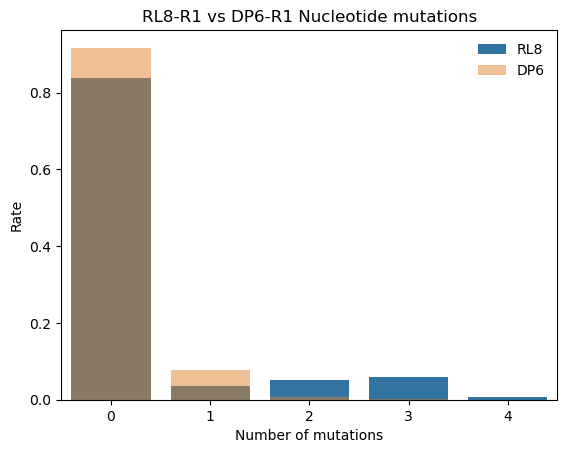

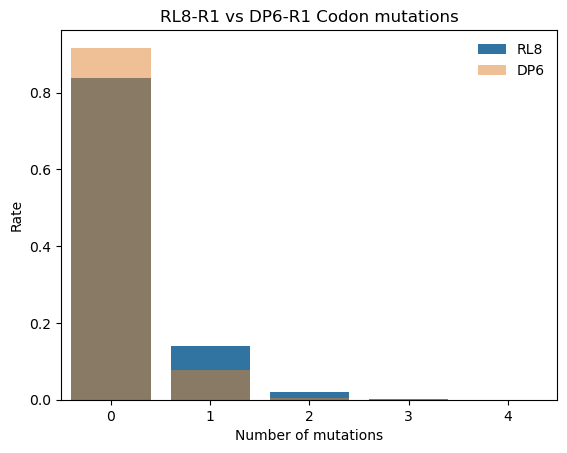

In [418]:
# rates of single, double, triple, ... mutations
total_reads = sum(DP6_n_Nt_mutations.values())
DP6_n_Nt_mutation_rates = {key: value/total_reads for key, value in DP6_n_Nt_mutations.items()}

total_reads = sum(DP6_n_Codon_mutations.values())
DP6_n_Codon_mutation_rates = {key: value/total_reads for key, value in DP6_n_Codon_mutations.items()}


total_reads = sum(RL8_n_Nt_mutations.values())
RL8_n_Nt_mutation_rates = {key: value/total_reads for key, value in RL8_n_Nt_mutations.items()}

total_reads = sum(RL8_n_Codon_mutations.values())
RL8_n_Codon_mutation_rates = {key: value/total_reads for key, value in RL8_n_Codon_mutations.items()}

sns.barplot(RL8_n_Nt_mutation_rates, label = "RL8")
sns.barplot(DP6_n_Nt_mutation_rates, alpha = 0.5, label = "DP6")
plt.legend(frameon = False)
plt.xlim(-0.5,4.5)
plt.xlabel('Number of mutations')
plt.ylabel('Rate')
plt.title(f'{variant}-R1 vs DP6-R1 Nucleotide mutations') 
plt.savefig(f'figures/RL8-R1_vs_DP6-R1_n_Nt_mutation_per_read_rates.pdf')
plt.show()
plt.clf()

sns.barplot(RL8_n_Codon_mutation_rates, label = "RL8")
sns.barplot(DP6_n_Codon_mutation_rates, alpha = 0.5, label = "DP6")
plt.legend(frameon = False)
plt.xlim(-0.5,4.5)
plt.xlabel('Number of mutations')
plt.ylabel('Rate')
plt.title(f'{variant}-R1 vs DP6-R1 Codon mutations') 
plt.savefig(f'figures/RL8-R1_vs_DP6-R1_n_Codon_mutation_per_read_rates.pdf')
plt.show()